<a href="https://colab.research.google.com/github/immischein/ML-bandgap/blob/main/model_building_nikodemas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Packages

In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.8 MB/s eta 0:00:00


# Imports

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

import shap
import category_encoders as ce
import time



# Data Imports and Processing


If Running Locally

In [113]:
# import sys
# sys.path.append('/content/drive/MyDrive/ColabImports')

# Load the CSV file (update the path to match your local filesystem)
# df = pd.read_csv('FILE PATH')  # e.g., './data/bandgap_dataset_premium.csv'
# print(df.head())

In [114]:
from google.colab import drive
drive.mount('/content/drive')


df = pd.read_csv('/content/drive/MyDrive/Project Documents ML-CMT/bandgap_dataset_premium.csv')

# Quick check
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  material_id  band_gap  formula   density       volume          a          b  \
0    mp-11107    3.5226    Ac2O3  9.109130    91.511224   4.095487   4.095489   
1    mp-32800    2.2962    Ac2S3  6.535149  1118.407852  14.997851  14.997851   
2   mp-977351    3.0275    Ac2S3  5.562971   328.464893   7.619779   7.619773   
3   mp-867311    0.0794  AcAgTe2  7.997421   122.518406   5.574922   5.574922   
4  mp-1183115    4.1024   AcAlO3  8.728230    57.451413   3.858634   3.858634   

           c       alpha        beta  ...      std_am  avg_vdw  vdw_range  \
0   6.299882   90.000000   90.000000  ...  103.368761    1.900       0.95   
1  14.997851  144.742139  144.742139  ...   95.498257    2.068       0.67   
2   7.875664  118.930903   61.069136  ...   95.498257    2.068       0.67   
3   5.574922   60.000000   60.000000  ...   46.591170    2.175       0.41   

In [115]:
df.head()

,material_id,band_gap,formula,density,volume,a,b,c,alpha,beta,...,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw,vbm,cbm,bulk_modulus,shear_modulus
0,mp-11107,3.5226,Ac2O3,9.109130,91.511224,4.095487,4.095489,6.299882,90.000000,90.000000,...,103.368761,1.900,0.95,2.47,1.52,0.465403,4.5896,8.1122,"{'voigt': 106.531, 'reuss': 96.061, 'vrh': 101...","{'voigt': 42.704, 'reuss': 28.813, 'vrh': 35.758}"
1,mp-32800,2.2962,Ac2S3,6.535149,1118.407852,14.997851,14.997851,14.997851,144.742139,144.742139,...,95.498257,2.068,0.67,2.47,1.80,0.328232,4.8014,7.0976,NaN,NaN
2,mp-977351,3.0275,Ac2S3,5.562971,328.464893,7.619779,7.619773,7.875664,118.930903,61.069136,...,95.498257,2.068,0.67,2.47,1.80,0.328232,2.9069,5.9344,NaN,NaN
3,mp-867311,0.0794,AcAgTe2,7.997421,122.518406,5.574922,5.574922,5.574922,60.000000,60.000000,...,46.591170,2.175,0.41,2.47,2.06,0.171537,5.9961,6.0755,NaN,NaN
4,mp-1183115,4.1024,AcAlO3,8.728230,57.451413,3.858634,3.858634,3.858634,90.000000,90.000000,...,83.410543,1.774,0.95,2.47,1.52,0.369410,6.8036,10.9060,NaN,NaN


In [116]:
# To test script: load dummy data

#from sklearn.datasets import fetch_openml

# Load a regression dataset from OpenML
#data = fetch_openml(name="house_prices", as_frame=True)  # Ames housing data
#df = data.frame

# Rename target to match our script
#df = df.rename(columns={"SalePrice": "band_gap"})

In [117]:
df.head()

,material_id,band_gap,formula,density,volume,a,b,c,alpha,beta,...,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw,vbm,cbm,bulk_modulus,shear_modulus
0,mp-11107,3.5226,Ac2O3,9.109130,91.511224,4.095487,4.095489,6.299882,90.000000,90.000000,...,103.368761,1.900,0.95,2.47,1.52,0.465403,4.5896,8.1122,"{'voigt': 106.531, 'reuss': 96.061, 'vrh': 101...","{'voigt': 42.704, 'reuss': 28.813, 'vrh': 35.758}"
1,mp-32800,2.2962,Ac2S3,6.535149,1118.407852,14.997851,14.997851,14.997851,144.742139,144.742139,...,95.498257,2.068,0.67,2.47,1.80,0.328232,4.8014,7.0976,NaN,NaN
2,mp-977351,3.0275,Ac2S3,5.562971,328.464893,7.619779,7.619773,7.875664,118.930903,61.069136,...,95.498257,2.068,0.67,2.47,1.80,0.328232,2.9069,5.9344,NaN,NaN
3,mp-867311,0.0794,AcAgTe2,7.997421,122.518406,5.574922,5.574922,5.574922,60.000000,60.000000,...,46.591170,2.175,0.41,2.47,2.06,0.171537,5.9961,6.0755,NaN,NaN
4,mp-1183115,4.1024,AcAlO3,8.728230,57.451413,3.858634,3.858634,3.858634,90.000000,90.000000,...,83.410543,1.774,0.95,2.47,1.52,0.369410,6.8036,10.9060,NaN,NaN


In [118]:
# Data inspection

print("Data shape:", df.shape)

missing = df.isnull().sum()
missing = missing[missing > 0]
print("Missing values per column:")
for col, n in missing.items():
    print(f"{col}: {n}")

display(df.describe())

Data shape: (82998, 40)
Missing values per column:
formula: 1
avg_en: 9
max_en: 9
min_en: 9
std_en: 9
vbm: 876
cbm: 876
bulk_modulus: 79092
shear_modulus: 79092


,band_gap,density,volume,a,b,c,alpha,beta,gamma,n_atoms,...,max_am,min_am,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw,vbm,cbm
count,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,...,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82122.000000,82122.000000
mean,1.984421,4.061805,668.913474,7.669236,8.044636,11.280915,86.028830,88.065828,89.700249,42.406058,...,110.699981,17.901714,31.772083,1.769480,0.787753,2.316020,1.528267,0.290510,1.585835,3.591381
std,1.560981,1.717274,693.624420,3.177138,2.800604,6.822619,17.420383,15.977789,22.074143,40.632079,...,57.428377,18.988597,20.400828,0.193034,0.380579,0.355453,0.203977,0.132925,2.238984,2.214685
min,0.000000,0.020144,11.286588,2.363000,2.363000,2.395898,3.664087,5.397478,5.397478,1.000000,...,1.007940,1.007940,0.000000,1.100000,0.000000,1.100000,1.100000,0.000000,-14.222600,-7.360600
25%,0.653400,2.913572,254.760639,5.553544,6.015389,7.389807,77.756958,88.952439,86.976837,16.000000,...,55.845000,6.941000,15.265807,1.666000,0.540000,2.070000,1.520000,0.207338,0.166850,2.368150
50%,1.728450,3.773981,452.574159,7.012094,7.718989,9.712402,90.000000,90.000000,90.000000,29.000000,...,106.420000,15.999400,26.508649,1.729333,0.720000,2.230000,1.520000,0.267822,1.629350,3.660450
75%,3.013225,4.954535,841.664286,8.965331,9.328646,13.157808,90.000000,90.000000,99.717832,54.000000,...,151.964000,15.999400,45.960918,1.855000,0.970000,2.430000,1.520000,0.348872,2.952475,4.974900
max,17.891400,18.889325,20090.906408,46.210701,61.125585,211.425839,169.783994,169.783994,168.048246,444.000000,...,244.000000,227.000000,107.897541,3.430000,2.330000,3.430000,3.430000,1.165000,12.376100,14.341400


In [119]:
# Drop columns that are prohibited

df = df.drop(columns='vbm')
df = df.drop(columns='cbm')
df = df.drop(columns='formula')
df = df.drop(columns='material_id')

# Band Gap Range

In [120]:
# Specify your band gap values
# df_subset = df[(df['band_gap'] >= 0.001) & (df['band_gap'] <= 5)]
min_band_gap = 0.001
max_band_gap = 50
df_subset = df[(df['band_gap'] >= min_band_gap) & (df['band_gap'] <= max_band_gap)]
display(df_subset.describe())

,band_gap,density,volume,a,b,c,alpha,beta,gamma,n_atoms,...,std_ie,avg_am,max_am,min_am,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw
count,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,...,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000
mean,2.008621,4.033431,672.461985,7.684102,8.062514,11.301802,86.022149,88.083887,89.751261,42.681004,...,3.015456,41.806994,110.408409,17.531845,31.728694,1.767303,0.792940,2.317925,1.524985,0.292209
std,1.554917,1.674945,694.552196,3.176485,2.790923,6.802653,17.335792,15.883331,22.025312,40.714649,...,1.026880,27.205139,57.213171,18.062631,20.351142,0.191568,0.379161,0.356644,0.200925,0.132420
min,0.001000,0.020144,11.286588,2.363000,2.363000,2.395898,5.200300,5.397478,5.397478,1.000000,...,0.000000,1.007940,1.007940,1.007940,0.000000,1.100000,0.000000,1.100000,1.100000,0.000000
25%,0.688100,2.909166,257.364387,5.564078,6.028705,7.420564,77.817055,88.983131,87.252454,16.000000,...,2.416645,22.943680,55.845000,6.941000,15.278718,1.665500,0.540000,2.070000,1.520000,0.209335
50%,1.754650,3.756501,456.001697,7.028730,7.739968,9.731572,90.000000,90.000000,90.000000,30.000000,...,3.116394,31.789136,102.905500,15.999400,26.416604,1.728373,0.750000,2.230000,1.520000,0.268755
75%,3.031600,4.921850,845.734409,8.975985,9.344012,13.179710,90.000000,90.000000,99.687205,54.000000,...,3.607667,52.994662,150.360000,15.999400,45.925766,1.851395,0.970000,2.430000,1.520000,0.350143
max,17.891400,16.321559,20090.906408,46.210701,56.617301,211.425839,169.783994,169.783994,168.048246,444.000000,...,6.764457,218.862254,244.000000,208.980400,107.897541,3.430000,2.330000,3.430000,3.430000,1.165000


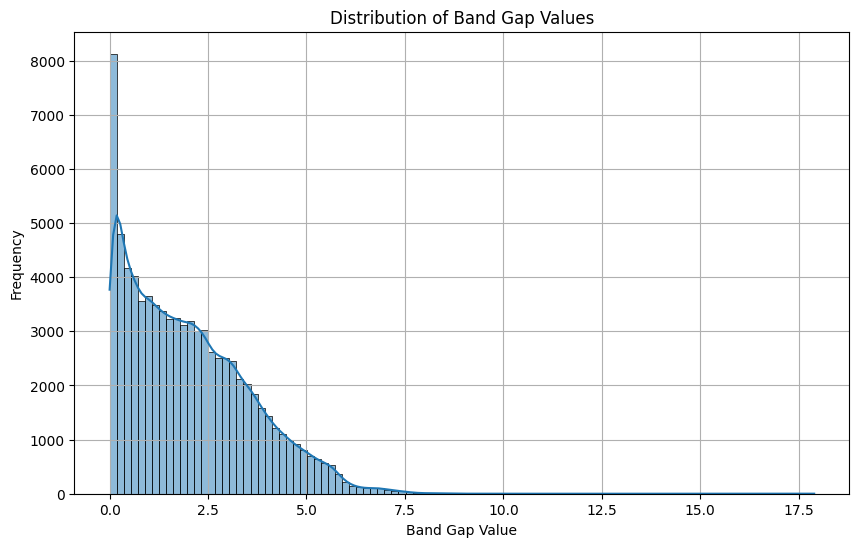

In [121]:
# Make a plot of band gap values based on occurences
plt.figure(figsize=(10, 6))
sns.histplot(df_subset['band_gap'], bins=100, kde=True)
plt.title('Distribution of Band Gap Values')
plt.xlabel('Band Gap Value')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Define features and target

In [122]:
target_column = "band_gap"
X = df_subset.drop(columns=[target_column])
y = df_subset[target_column]

# Seperate numeric and categorical columns

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocessing

In [123]:
# To decide: drop columns with >65% missing values (can be lower, based on this dummy dataset)

threshold = 0.65
missing_frac = df_subset.isnull().mean()
cols_to_drop = missing_frac[missing_frac > threshold].index

print(f"Dropping columns with >{int(threshold*100)}% missing values:")
print(list(cols_to_drop))

df_subset = df_subset.drop(columns=cols_to_drop)

# To decide: impute missing numerical values with mean, categorical features with most frequent value
# StandardScaler subtracts mean and divides by std
# Use onehotencoder for categorical features


# Split into train and test sets BEFORE preprocessing
X = df_subset.drop("band_gap", axis=1)   # Replace "target" with your actual target column name
y = df_subset["band_gap"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Target Encoding on training set only
# Convert a meaningufl categorical feature into a numerical one. This is more dense that one-hot encoding
# Transform a categorical variable into a numerical one using the mean of the target variable for each category
te_col = "spacegroup_number "
te_encoder = ce.TargetEncoder(cols=[te_col])
# apply target encoding on training set
X_train[te_col] = te_encoder.fit_transform(X_train[te_col], y_train)

# apply target encoding on test set
X_test[te_col] = te_encoder.transform(X_test[te_col])


# Proceed with rest of pre-processing pipeline
# Separate numeric and categorical columns again after dropping columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Numeric features are imputed with the mean and then scaled
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="mean"), # fill missing values with mean
    StandardScaler()
)
# Categorical features are imputed with the most frequent value and then one-hot encoded
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"), # fill missing values with most frequent value
    OneHotEncoder(handle_unknown="ignore") # one-hot encode categorical features
)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Fit and transform the training data, and transform the test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

Dropping columns with >65% missing values:
['bulk_modulus', 'shear_modulus']


# Define the models to compare

In [14]:
models = {
    "Dummy": DummyRegressor(),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0), # Alpha is the regularization strength which penalizes large coefficients
    # Polynomaial regression with Ridge regularization (captures cubic relationships and ridge handles overfitting)
    # "Polynomial Regression": make_pipeline(
    #     PolynomialFeatures(degree=3, include_bias=False),
    #     StandardScaler(),
    #     Ridge(alpha=1.0)
    # ),
    # "Ridge": RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=100, # number of trees
        learning_rate=0.1, # step size shrinkage
        max_depth=3, # maximum depth of the individual trees
        random_state=42 # for reproducibility
    ),
    # #
    "XGBoost": XGBRegressor(
        n_estimators=100, # number of trees
        learning_rate=0.1, # step size shrinkage
        max_depth=3,
        random_state=42,
        n_jobs=-1 # use all available cores
    ),
    # Hist Gradient Boosting with hyperparameters
    "Hist Gradient Boosting": HistGradientBoostingRegressor(
        max_iter=100, # number of trees
        learning_rate=0.1, # step size shrinkage
        max_depth=3,
        random_state=42
    ),
    # Random Forest with hyperparameters
    "Random Forest": RandomForestRegressor(
    random_state=42,
    n_estimators=200, # number of trees
    max_depth=None, # maximum depth of the individual trees is unlimited
    min_samples_leaf=3, # minimum number of samples required to be at a leaf node
    min_samples_split=5, # minimum number of samples required to split an internal node
    max_features='sqrt', # number of features to consider when looking for the best split
    oob_score=True, # use out-of-bag samples to estimate the generalization accuracy
    n_jobs=-1
),
    "Random Forest (tuned)" : RandomForestRegressor(
    random_state=42,
    n_estimators=300, # number of trees
    max_depth=None, # maximum depth of the individual trees is unlimited
    min_samples_leaf=1, # minimum number of samples required to be at a leaf node
    min_samples_split=3, # minimum number of samples required to split an internal node
    max_features='sqrt', # number of features to consider when looking for the best split
    oob_score=True, # use out-of-bag samples to estimate the generalization accuracy
    n_jobs=-1
    )
}

# Model training

In [15]:
# train models
# Cross validation with 5 folds is a typical choice
print("\nCross-validated MAE (5-fold):")
for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    scores = cross_val_score(pipeline, X_train, y_train,
                             scoring="neg_mean_absolute_error", cv=5)
    print(f"{name}: MAE = {-np.mean(scores):.3f}")


Cross-validated MAE (5-fold):
Dummy: MAE = 1.279
Linear Regression: MAE = 1.091
Ridge Regression: MAE = 1.091
Gradient Boosting: MAE = 0.922
XGBoost: MAE = 0.922
Hist Gradient Boosting: MAE = 0.921
Random Forest: MAE = 0.714
Random Forest (tuned): MAE = 0.692


In [16]:
# Evaluate data on random forest model from above with manual preprocessing
models["Random Forest"].fit(X_train_processed, y_train)
y_pred = models["Random Forest"].predict(X_test_processed)
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred))


Random Forest MAE: 0.6890349639914011


In [17]:
models["Hist Gradient Boosting"].fit(X_train_processed, y_train)
y_pred = models["Hist Gradient Boosting"].predict(X_test_processed)
print("Hist Gradient Boosting MAE:", mean_absolute_error(y_test, y_pred))

Hist Gradient Boosting MAE: 0.9203439857513734


# Evaluate model


Test set performance:
Dummy: MAE = 1.270, R² = -0.000
Linear Regression: MAE = 1.091, R² = 0.224
Ridge Regression: MAE = 1.091, R² = 0.224
Gradient Boosting: MAE = 0.923, R² = 0.433
XGBoost: MAE = 0.924, R² = 0.431
Hist Gradient Boosting: MAE = 0.920, R² = 0.434
Random Forest: MAE = 0.689, R² = 0.635
Random Forest (tuned): MAE = 0.666, R² = 0.651


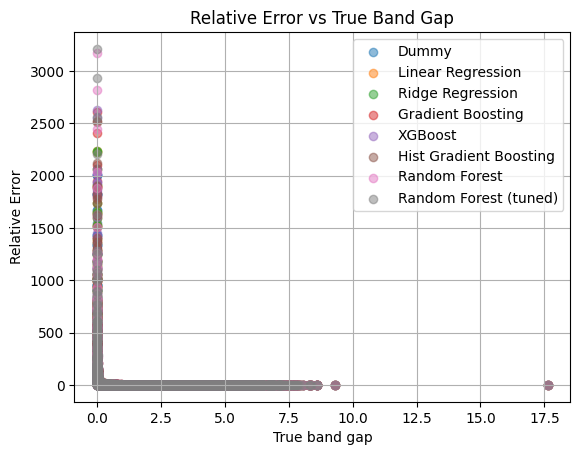

In [18]:
# Fit on full training set and evaluate on test set
results = {}
print("\nTest set performance:")
for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"mae": mae, "r2": r2}

    print(f"{name}: MAE = {mae:.3f}, R² = {r2:.3f}")

    # Plot MAE vs true value
    relative_error = np.abs(y_pred - y_test) / y_test
    plt.scatter(y_test, relative_error, label=name, alpha=0.5)

    #plt.scatter(y_test, np.abs(y_pred - y_test), label=name, alpha=0.5)

plt.xlabel("True band gap")
plt.ylabel("Relative Error")
plt.title("Relative Error vs True Band Gap")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# # Feature importance of tree based model
# rf_model = make_pipeline(preprocessor, RandomForestRegressor(random_state=42))
# rf_model.fit(X_train, y_train)

# importances = rf_model.named_steps["randomforestregressor"].feature_importances_

# # Get feature names from the preprocessor
# feature_names = rf_model.named_steps["columntransformer"].get_feature_names_out()

# # Sort by importance
# sorted_idx = np.argsort(importances)[::-1][:20]
# top_features = np.array(feature_names)[sorted_idx]
# top_importances = importances[sorted_idx]

# plt.figure(figsize=(10, 6))
# sns.barplot(x=top_importances, y=top_features)
# plt.title("Top 20 Random Forest Feature Importances")
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.tight_layout()
# plt.show()


# Feature importance using SHAP

In [20]:
# # Feature importance using SHAP
# rf = rf_model.named_steps["randomforestregressor"]
# X_transformed = rf_model.named_steps["columntransformer"].transform(X_test)

# if hasattr(X_transformed, "toarray"):
#     X_transformed = X_transformed.toarray()

# feature_names = rf_model.named_steps["columntransformer"].get_feature_names_out()

# explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(X_transformed)

# shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)


In [21]:
# # Using a faster SHAP explainer
# rf = rf_model.named_steps["randomforestregressor"]

# # Sample fewer rows for faster explanation
# X_sample = X_test.sample(250, random_state=42)

# # Transform using your pipeline
# X_transformed = rf_model.named_steps["columntransformer"].transform(X_sample)

# # Only convert if needed
# if hasattr(X_transformed, "toarray"):
#     X_transformed = X_transformed.toarray()

# # Get feature names
# feature_names = rf_model.named_steps["columntransformer"].get_feature_names_out()

# # Use SHAP's auto-detect explainer (faster in new versions)
# explainer = shap.Explainer(rf)

# # Compute SHAP values
# shap_values = explainer(X_transformed)

# # Summary plot
# shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)


# Deep Learning Code

## Multilayer Perceptron (MLP)

In [22]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [23]:
# Model training
# mlp = MLPRegressor(hidden_layer_sizes=(500, 50),
#                    batch_size=32,
#                    learning_rate_init=0.001,
#                    activation='relu',
#                    solver='adam',
#                    max_iter=500,
#                    random_state=42,
#                    early_stopping=True,
#                    validation_fraction=0.01,
#                    verbose=True)

# mlp.fit(X_train_processed, y_train)

In [24]:
mlp = MLPRegressor(
    hidden_layer_sizes=(512, 256, 64),     # deeper & wider architecture
    activation='relu',                     # good default; try 'tanh' as well
    solver='adam',                         # adaptive optimizer
    alpha=1e-4,                            # L2 regularization (prevents overfitting)
    batch_size=32,                         # reasonable mini-batch size
    learning_rate='adaptive',              # allows decay if loss plateaus
    learning_rate_init=0.001,              # starting learning rate
    max_iter=1000,                         # more iterations for convergence
    early_stopping=True,                   # stop if no improvement on val
    validation_fraction=0.1,               # more validation data
    n_iter_no_change=20,                   # patience for early stopping
    random_state=42,
    verbose=True
)

mlp.fit(X_train_processed, y_train)

Iteration 1, loss = 0.83597124
Validation score: 0.375469
Iteration 2, loss = 0.73955677
Validation score: 0.402416
Iteration 3, loss = 0.69672106
Validation score: 0.416925
Iteration 4, loss = 0.67061408
Validation score: 0.459969
Iteration 5, loss = 0.64457770
Validation score: 0.473381
Iteration 6, loss = 0.62612703
Validation score: 0.477155
Iteration 7, loss = 0.60648886
Validation score: 0.466453
Iteration 8, loss = 0.58860904
Validation score: 0.489695
Iteration 9, loss = 0.57455431
Validation score: 0.501443
Iteration 10, loss = 0.55880841
Validation score: 0.485660
Iteration 11, loss = 0.54639937
Validation score: 0.501837
Iteration 12, loss = 0.53199809
Validation score: 0.510686
Iteration 13, loss = 0.52113577
Validation score: 0.495092
Iteration 14, loss = 0.50765451
Validation score: 0.518908
Iteration 15, loss = 0.49432054
Validation score: 0.505463
Iteration 16, loss = 0.48294069
Validation score: 0.512196
Iteration 17, loss = 0.47170624
Validation score: 0.515270
Iterat

MLPRegressor(batch_size=32, early_stopping=True,
             hidden_layer_sizes=(512, 256, 64), learning_rate='adaptive',
             max_iter=1000, n_iter_no_change=20, random_state=42, verbose=True)

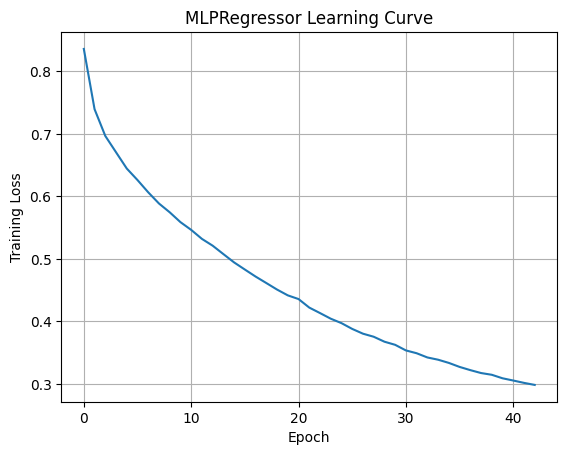

In [25]:
# Plot learning curve
plt.plot(mlp.loss_curve_)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("MLPRegressor Learning Curve")
plt.grid(True)
plt.show()

In [26]:
# Evaluate performance
y_pred_sklearn = mlp.predict(X_test_processed)

mae_mlp = mean_absolute_error(y_test, y_pred_sklearn)
r2_mlp = r2_score(y_test, y_pred_sklearn)
mse_mlp = mean_squared_error(y_test, y_pred_sklearn)
rmse_mlp = np.sqrt(mse_mlp)

print(f"[MLPRegressor]")
print(f"MAE:  {mae_mlp:.4f}")
print(f"RMSE: {rmse_mlp:.4f}")
print(f"R²:   {r2_mlp:.4f}")


[MLPRegressor]
MAE:  0.8047
RMSE: 1.0788
R²:   0.5179


# Deep Neural Network

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

In [133]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed.toarray()
                              if hasattr(X_train_processed, "toarray")
                              else X_train_processed, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_processed.toarray()
                             if hasattr(X_test_processed, "toarray")
                             else X_test_processed, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

## 3 Layers Network

In [100]:
# Define model
class DeepRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)

        )

    def forward(self, x):

        return self.net(x)

model_layers3 = DeepRegressor(X_train_tensor.shape[1])


### Run the model on GPU if available

In [101]:
# Put the model on the GPU if available
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal GPU on Mac
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU (not on Mac usually)
else:
    device = torch.device("cpu")  # Fallback

print("Using device:", device)

model_layers3.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print(X_train_tensor.device)
print(y_train_tensor.device)

Using device: cuda
cuda:0
cuda:0


In [102]:
# # Train model and register learning curve

# # Start timing
# start_time = time.time()

# # Define loss function: Mean Squared Error is commonly used for regression
# criterion = nn.MSELoss()

# # Define optimizer: Adam is an adaptive optimizer that generally performs well
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Lists to store training and test loss values at each epoch (for plotting/monitoring)
# train_losses = []
# test_losses = []

# # Set total number of training epochs
# n_epochs = 10000

# # Start the training loop
# for epoch in range(n_epochs):
#     # Set the model to training mode (activates dropout, batchnorm, etc. if used)
#     model.train()

#     # Clear previous gradients to prevent accumulation
#     optimizer.zero_grad()

#     # Forward pass: predict training outputs using current model weights
#     y_pred_train = model(X_train_tensor)

#     # Compute training loss by comparing predictions to ground truth
#     loss = criterion(y_pred_train, y_train_tensor)

#     # Backward pass: compute gradients of the loss w.r.t. model parameters
#     loss.backward()

#     # Update model weights using the computed gradients
#     optimizer.step()

#     # Switch model to evaluation mode (disables dropout, uses running stats for batchnorm)
#     model.eval()

#     # Disable gradient computation during inference to save memory and improve speed
#     with torch.no_grad():
#         # Predict outputs on the test set
#         y_pred_test = model(X_test_tensor)

#         # Compute test loss for evaluation
#         test_loss = criterion(y_pred_test, y_test_tensor)

#     # Record training and test loss values for this epoch
#     train_losses.append(loss.item())
#     test_losses.append(test_loss.item())

#     # Print progress every 10 epochs
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}: Train Loss={loss.item():.4f}, Test Loss={test_loss.item():.4f}")

# # End timing
# end_time = time.time()
# training_time_3layers = end_time - start_time
# print(f"Training time: {training_time_3layers:.2f} seconds")


### Define the training loop

In [103]:
import time
from tqdm import trange
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(
    model,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    n_epochs=5000,
    lr=0.001,
    weight_decay=0,
    early_stop_patience=200,
    scheduler_patience=50,
    scheduler_factor=0.5,
    verbose_every=10
):
    """
    Trains a PyTorch regression model with early stopping and learning rate scheduling.

    Returns:
        model: The trained model with best weights
        train_losses: List of training loss per epoch
        test_losses: List of test loss per epoch
    """

    # Setup
    start_time = time.time()
    criterion = nn.MSELoss()  # Mean squared error loss for regression
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience
    )  # Reduce LR on plateau

    train_losses = []
    test_losses = []
    best_loss = float('inf')
    trigger_times = 0

    for epoch in trange(n_epochs, desc="Training"):
        model.train()
        optimizer.zero_grad()
        y_pred_train = model(X_train_tensor)  # Forward pass on train set
        loss = criterion(y_pred_train, y_train_tensor)  # Compute train loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        model.eval()
        with torch.no_grad():
            y_pred_test = model(X_test_tensor)  # Forward pass on test set
            test_loss = criterion(y_pred_test, y_test_tensor)  # Compute test loss

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        scheduler.step(test_loss.item())  # Step the LR scheduler

        # Early stopping logic
        if test_loss.item() < best_loss:
            best_loss = test_loss.item()
            best_model_state = model.state_dict()  # Save best model weights
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= early_stop_patience:
                print(f"\n⏹️ Early stopping at epoch {epoch}")
                break
        if epoch % verbose_every == 0:
            print(f"Epoch {epoch:4d} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f}")

    # Restore best model weights after training
    model.load_state_dict(best_model_state)

    # Report training time
    end_time = time.time()
    duration = end_time - start_time
    print(f"\n✅ Training completed in {duration:.2f} seconds ({duration / 60:.2f} minutes)")

    return model, train_losses, test_losses


### Train the Model

In [104]:
model_layers3, train_losses_layers3, test_losses_layers3 = train_model(
    model_layers3,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    n_epochs=5000,
    lr=0.001,
    weight_decay=0,
    early_stop_patience=200,
    scheduler_patience=50,
    scheduler_factor=0.5,
    verbose_every=20
)

Training:   2%|▏         | 82/5000 [00:00<00:12, 406.23it/s]

Epoch    0 | Train Loss: 6.3034 | Test Loss: 6.0418
Epoch   20 | Train Loss: 2.4132 | Test Loss: 2.3784
Epoch   40 | Train Loss: 2.0385 | Test Loss: 2.0492
Epoch   60 | Train Loss: 1.9166 | Test Loss: 1.9386
Epoch   80 | Train Loss: 1.8579 | Test Loss: 1.8804


Training:   3%|▎         | 165/5000 [00:00<00:11, 407.22it/s]

Epoch  100 | Train Loss: 1.8217 | Test Loss: 1.8453
Epoch  120 | Train Loss: 1.7925 | Test Loss: 1.8170
Epoch  140 | Train Loss: 1.7657 | Test Loss: 1.7907
Epoch  160 | Train Loss: 1.7410 | Test Loss: 1.7669
Epoch  180 | Train Loss: 1.7174 | Test Loss: 1.7443


Training:   5%|▍         | 247/5000 [00:00<00:11, 404.82it/s]

Epoch  200 | Train Loss: 1.6941 | Test Loss: 1.7221
Epoch  220 | Train Loss: 1.6700 | Test Loss: 1.6988
Epoch  240 | Train Loss: 1.6449 | Test Loss: 1.6750
Epoch  260 | Train Loss: 1.6185 | Test Loss: 1.6501
Epoch  280 | Train Loss: 1.5911 | Test Loss: 1.6245


Training:   7%|▋         | 370/5000 [00:00<00:11, 403.64it/s]

Epoch  300 | Train Loss: 1.5636 | Test Loss: 1.6002
Epoch  320 | Train Loss: 1.5370 | Test Loss: 1.5765
Epoch  340 | Train Loss: 1.5115 | Test Loss: 1.5541
Epoch  360 | Train Loss: 1.4872 | Test Loss: 1.5337
Epoch  380 | Train Loss: 1.4636 | Test Loss: 1.5136


Training:   9%|▉         | 452/5000 [00:01<00:11, 401.93it/s]

Epoch  400 | Train Loss: 1.4410 | Test Loss: 1.4943
Epoch  420 | Train Loss: 1.4196 | Test Loss: 1.4755
Epoch  440 | Train Loss: 1.3994 | Test Loss: 1.4582
Epoch  460 | Train Loss: 1.3806 | Test Loss: 1.4431
Epoch  480 | Train Loss: 1.3625 | Test Loss: 1.4287


Training:  12%|█▏        | 575/5000 [00:01<00:10, 404.29it/s]

Epoch  500 | Train Loss: 1.3439 | Test Loss: 1.4156
Epoch  520 | Train Loss: 1.3258 | Test Loss: 1.4031
Epoch  540 | Train Loss: 1.3093 | Test Loss: 1.3910
Epoch  560 | Train Loss: 1.2942 | Test Loss: 1.3794
Epoch  580 | Train Loss: 1.2803 | Test Loss: 1.3686


Training:  13%|█▎        | 657/5000 [00:01<00:10, 404.70it/s]

Epoch  600 | Train Loss: 1.2676 | Test Loss: 1.3592
Epoch  620 | Train Loss: 1.2569 | Test Loss: 1.3516
Epoch  640 | Train Loss: 1.2461 | Test Loss: 1.3444
Epoch  660 | Train Loss: 1.2372 | Test Loss: 1.3391
Epoch  680 | Train Loss: 1.2291 | Test Loss: 1.3335


Training:  16%|█▌        | 780/5000 [00:01<00:10, 407.58it/s]

Epoch  700 | Train Loss: 1.2217 | Test Loss: 1.3290
Epoch  720 | Train Loss: 1.2147 | Test Loss: 1.3252
Epoch  740 | Train Loss: 1.2085 | Test Loss: 1.3219
Epoch  760 | Train Loss: 1.2022 | Test Loss: 1.3171
Epoch  780 | Train Loss: 1.1963 | Test Loss: 1.3134


Training:  17%|█▋        | 862/5000 [00:02<00:10, 405.31it/s]

Epoch  800 | Train Loss: 1.1932 | Test Loss: 1.3111
Epoch  820 | Train Loss: 1.1863 | Test Loss: 1.3068
Epoch  840 | Train Loss: 1.1811 | Test Loss: 1.3041
Epoch  860 | Train Loss: 1.1766 | Test Loss: 1.3026
Epoch  880 | Train Loss: 1.1714 | Test Loss: 1.2982


Training:  19%|█▉        | 944/5000 [00:02<00:10, 403.59it/s]

Epoch  900 | Train Loss: 1.1664 | Test Loss: 1.2949
Epoch  920 | Train Loss: 1.1627 | Test Loss: 1.2933
Epoch  940 | Train Loss: 1.1567 | Test Loss: 1.2890
Epoch  960 | Train Loss: 1.1527 | Test Loss: 1.2876
Epoch  980 | Train Loss: 1.1474 | Test Loss: 1.2842


Training:  21%|██▏       | 1067/5000 [00:02<00:09, 404.58it/s]

Epoch 1000 | Train Loss: 1.1437 | Test Loss: 1.2828
Epoch 1020 | Train Loss: 1.1391 | Test Loss: 1.2809
Epoch 1040 | Train Loss: 1.1358 | Test Loss: 1.2786
Epoch 1060 | Train Loss: 1.1327 | Test Loss: 1.2785
Epoch 1080 | Train Loss: 1.1271 | Test Loss: 1.2747


Training:  23%|██▎       | 1149/5000 [00:02<00:09, 405.62it/s]

Epoch 1100 | Train Loss: 1.1248 | Test Loss: 1.2740
Epoch 1120 | Train Loss: 1.1201 | Test Loss: 1.2716
Epoch 1140 | Train Loss: 1.1187 | Test Loss: 1.2726
Epoch 1160 | Train Loss: 1.1132 | Test Loss: 1.2682
Epoch 1180 | Train Loss: 1.1102 | Test Loss: 1.2673


Training:  25%|██▌       | 1273/5000 [00:03<00:09, 405.51it/s]

Epoch 1200 | Train Loss: 1.1079 | Test Loss: 1.2655
Epoch 1220 | Train Loss: 1.1034 | Test Loss: 1.2637
Epoch 1240 | Train Loss: 1.0997 | Test Loss: 1.2623
Epoch 1260 | Train Loss: 1.0971 | Test Loss: 1.2620
Epoch 1280 | Train Loss: 1.0942 | Test Loss: 1.2611


Training:  27%|██▋       | 1356/5000 [00:03<00:08, 406.70it/s]

Epoch 1300 | Train Loss: 1.0913 | Test Loss: 1.2607
Epoch 1320 | Train Loss: 1.0874 | Test Loss: 1.2584
Epoch 1340 | Train Loss: 1.0851 | Test Loss: 1.2587
Epoch 1360 | Train Loss: 1.0823 | Test Loss: 1.2583
Epoch 1380 | Train Loss: 1.0790 | Test Loss: 1.2557


Training:  30%|██▉       | 1480/5000 [00:03<00:08, 407.22it/s]

Epoch 1400 | Train Loss: 1.0768 | Test Loss: 1.2553
Epoch 1420 | Train Loss: 1.0738 | Test Loss: 1.2539
Epoch 1440 | Train Loss: 1.0729 | Test Loss: 1.2538
Epoch 1460 | Train Loss: 1.0689 | Test Loss: 1.2525
Epoch 1480 | Train Loss: 1.0683 | Test Loss: 1.2538


Training:  31%|███       | 1562/5000 [00:03<00:08, 406.59it/s]

Epoch 1500 | Train Loss: 1.0643 | Test Loss: 1.2513
Epoch 1520 | Train Loss: 1.0631 | Test Loss: 1.2524
Epoch 1540 | Train Loss: 1.0600 | Test Loss: 1.2508
Epoch 1560 | Train Loss: 1.0582 | Test Loss: 1.2500
Epoch 1580 | Train Loss: 1.0563 | Test Loss: 1.2497


Training:  33%|███▎      | 1645/5000 [00:04<00:08, 407.77it/s]

Epoch 1600 | Train Loss: 1.0529 | Test Loss: 1.2478
Epoch 1620 | Train Loss: 1.0519 | Test Loss: 1.2483
Epoch 1640 | Train Loss: 1.0495 | Test Loss: 1.2465
Epoch 1660 | Train Loss: 1.0468 | Test Loss: 1.2454
Epoch 1680 | Train Loss: 1.0446 | Test Loss: 1.2448


Training:  35%|███▌      | 1770/5000 [00:04<00:07, 409.47it/s]

Epoch 1700 | Train Loss: 1.0427 | Test Loss: 1.2441
Epoch 1720 | Train Loss: 1.0410 | Test Loss: 1.2436
Epoch 1740 | Train Loss: 1.0406 | Test Loss: 1.2461
Epoch 1760 | Train Loss: 1.0378 | Test Loss: 1.2428
Epoch 1780 | Train Loss: 1.0350 | Test Loss: 1.2415


Training:  37%|███▋      | 1852/5000 [00:04<00:07, 406.52it/s]

Epoch 1800 | Train Loss: 1.0330 | Test Loss: 1.2407
Epoch 1820 | Train Loss: 1.0312 | Test Loss: 1.2405
Epoch 1840 | Train Loss: 1.0291 | Test Loss: 1.2398
Epoch 1860 | Train Loss: 1.0280 | Test Loss: 1.2395
Epoch 1880 | Train Loss: 1.0269 | Test Loss: 1.2396


Training:  40%|███▉      | 1976/5000 [00:04<00:07, 408.19it/s]

Epoch 1900 | Train Loss: 1.0243 | Test Loss: 1.2382
Epoch 1920 | Train Loss: 1.0218 | Test Loss: 1.2371
Epoch 1940 | Train Loss: 1.0206 | Test Loss: 1.2369
Epoch 1960 | Train Loss: 1.0191 | Test Loss: 1.2371
Epoch 1980 | Train Loss: 1.0199 | Test Loss: 1.2374


Training:  41%|████      | 2058/5000 [00:05<00:07, 406.78it/s]

Epoch 2000 | Train Loss: 1.0154 | Test Loss: 1.2358
Epoch 2020 | Train Loss: 1.0132 | Test Loss: 1.2354
Epoch 2040 | Train Loss: 1.0119 | Test Loss: 1.2358
Epoch 2060 | Train Loss: 1.0102 | Test Loss: 1.2349
Epoch 2080 | Train Loss: 1.0101 | Test Loss: 1.2371


Training:  44%|████▎     | 2182/5000 [00:05<00:06, 405.97it/s]

Epoch 2100 | Train Loss: 1.0075 | Test Loss: 1.2349
Epoch 2120 | Train Loss: 1.0055 | Test Loss: 1.2346
Epoch 2140 | Train Loss: 1.0044 | Test Loss: 1.2353
Epoch 2160 | Train Loss: 1.0018 | Test Loss: 1.2343
Epoch 2180 | Train Loss: 0.9996 | Test Loss: 1.2342


Training:  45%|████▌     | 2264/5000 [00:05<00:06, 404.63it/s]

Epoch 2200 | Train Loss: 0.9977 | Test Loss: 1.2335
Epoch 2220 | Train Loss: 0.9958 | Test Loss: 1.2338
Epoch 2240 | Train Loss: 0.9934 | Test Loss: 1.2337
Epoch 2260 | Train Loss: 0.9925 | Test Loss: 1.2329
Epoch 2280 | Train Loss: 0.9916 | Test Loss: 1.2327


Training:  47%|████▋     | 2346/5000 [00:05<00:06, 405.43it/s]

Epoch 2300 | Train Loss: 0.9907 | Test Loss: 1.2327
Epoch 2320 | Train Loss: 0.9898 | Test Loss: 1.2328
Epoch 2340 | Train Loss: 0.9892 | Test Loss: 1.2328
Epoch 2360 | Train Loss: 0.9887 | Test Loss: 1.2328
Epoch 2380 | Train Loss: 0.9883 | Test Loss: 1.2328


Training:  50%|████▉     | 2481/5000 [00:06<00:06, 405.63it/s]

Epoch 2400 | Train Loss: 0.9880 | Test Loss: 1.2328
Epoch 2420 | Train Loss: 0.9878 | Test Loss: 1.2328
Epoch 2440 | Train Loss: 0.9876 | Test Loss: 1.2328
Epoch 2460 | Train Loss: 0.9875 | Test Loss: 1.2328
Epoch 2480 | Train Loss: 0.9874 | Test Loss: 1.2328

⏹️ Early stopping at epoch 2481

✅ Training completed in 6.12 seconds (0.10 minutes)


### Evaluate the model

In [105]:
# Model evaluation
def evaluate_model(model, X_train_tensor, y_train, X_test_tensor, y_test, y_train_tensor=None):
    """
    Evaluates a trained PyTorch regression model on both training and test sets.

    Returns:
        Dictionary of metrics (MAE, RMSE, R²) for train and test sets
    """
    model.eval()

    with torch.no_grad():
        y_pred_test = model(X_test_tensor).detach().cpu().numpy()
        y_pred_train = model(X_train_tensor).detach().cpu().numpy()


    # Evaluate on test set
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred_test)

    # Evaluate on train set
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_pred_train)

    return {
        "test": {"MAE": mae_test, "RMSE": rmse_test, "R2": r2_test, "y_pred_test": y_pred_test},
        "train": {"MAE": mae_train, "RMSE": rmse_train, "R2": r2_train, "y_pred_train": y_pred_train}
    }

### Analyze the model

In [106]:
# Plot learning curves
import matplotlib.pyplot as plt

def analyze_model(metrics, y_test,
                  train_losses, test_losses, model_name="PyTorch Model"):
    """
    Plots learning curves, prints metrics, and plots predicted vs. true values.
    """

    # 2. Plot learning curves
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title(f"{model_name} Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3. Print metrics
    print(f"[{model_name} - Test Set]")
    print(f"MAE:  {metrics['test']['MAE']:.4f}")
    print(f"RMSE: {metrics['test']['RMSE']:.4f}")
    print(f"R²:   {metrics['test']['R2']:.4f}")
    print(f"\n[{model_name} - Training Set]")
    print(f"MAE:  {metrics['train']['MAE']:.4f}")
    print(f"RMSE: {metrics['train']['RMSE']:.4f}")
    print(f"R²:   {metrics['train']['R2']:.4f}")

    # 4. Plot predicted vs true values (test set)

    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, metrics['test']['y_pred_test'], alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel("True Band Gap")
    plt.ylabel("Predicted Band Gap")
    plt.title(f"{model_name} - Predicted vs True (Test Set)")
    plt.grid(True)
    plt.show()


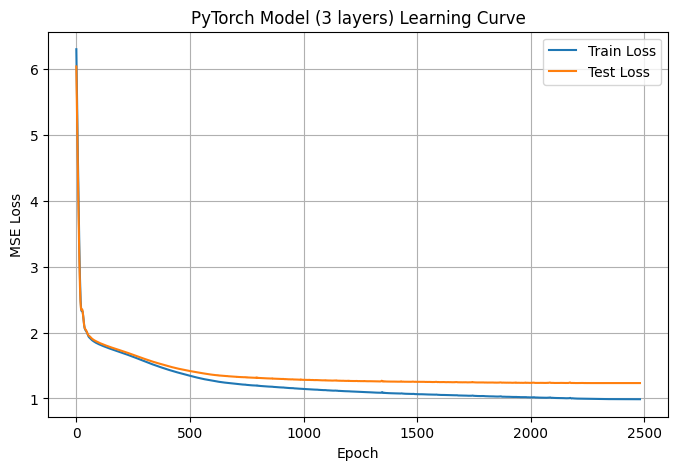

[PyTorch Model (3 layers) - Test Set]
MAE:  0.8363
RMSE: 1.1103
R²:   0.4893

[PyTorch Model (3 layers) - Training Set]
MAE:  0.7554
RMSE: 0.9937
R²:   0.5918


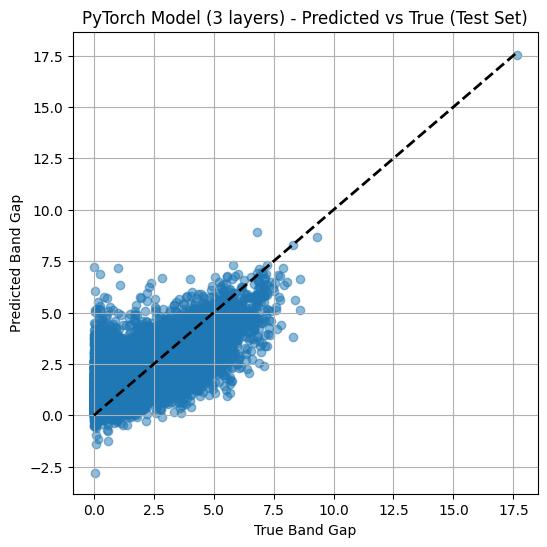

In [107]:
# Make a metrics dictionary
model_layers3_metrics = evaluate_model(
    model_layers3,
    X_train_tensor,
    y_train,
    X_test_tensor,
    y_test
)
# Analyze the model
analyze_model(
    model_layers3_metrics,
    y_test,
    train_losses_layers3,
    test_losses_layers3,
    model_name="PyTorch Model (3 layers)"
)

## 6 Layers Network

In [134]:
class DeepRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(  # Define the network layers
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2), # Drops 20% of neurons randomly during training

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2), # Drops 20% of neurons randomly during training

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 1)  # Output layer (no activation for regression)
        )

    def forward(self, x):
        return self.net(x)

# Initialize the model with the input dimension (number of features)
model_layers6 = DeepRegressor(X_train_tensor.shape[1])

In [135]:

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal GPU on Mac
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU (not on Mac usually)
else:
    device = torch.device("cpu")  # Fallback

print("Using device:", device)

model_layers6.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print(X_train_tensor.device)
print(y_train_tensor.device)

Using device: cuda
cuda:0
cuda:0


In [136]:
model_layers6, train_losses_layers6, test_losses_layers6 = train_model(
    model_layers6,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    n_epochs=5000,
    lr=0.001,
    weight_decay=0,
    early_stop_patience=200,
    scheduler_patience=50,
    scheduler_factor=0.5,
    verbose_every=20
)

Training:   0%|          | 13/5000 [00:00<00:41, 121.04it/s]

Epoch    0 | Train Loss: 7.3920 | Test Loss: 7.2681
Epoch   20 | Train Loss: 2.8003 | Test Loss: 2.9400


Training:   1%|▏         | 65/5000 [00:00<00:41, 120.07it/s]

Epoch   40 | Train Loss: 2.0740 | Test Loss: 2.0560
Epoch   60 | Train Loss: 1.9551 | Test Loss: 1.9372


Training:   2%|▏         | 103/5000 [00:00<00:40, 119.71it/s]

Epoch   80 | Train Loss: 1.9016 | Test Loss: 1.8869
Epoch  100 | Train Loss: 1.8655 | Test Loss: 1.8503


Training:   3%|▎         | 139/5000 [00:01<00:40, 118.74it/s]

Epoch  120 | Train Loss: 1.8338 | Test Loss: 1.8181
Epoch  140 | Train Loss: 1.8003 | Test Loss: 1.7837


Training:   4%|▎         | 175/5000 [00:01<00:40, 119.09it/s]

Epoch  160 | Train Loss: 1.7609 | Test Loss: 1.7445
Epoch  180 | Train Loss: 1.7307 | Test Loss: 1.7042


Training:   4%|▍         | 223/5000 [00:01<00:40, 119.24it/s]

Epoch  200 | Train Loss: 1.6937 | Test Loss: 1.6648
Epoch  220 | Train Loss: 1.6693 | Test Loss: 1.6287


Training:   5%|▌         | 259/5000 [00:02<00:39, 118.92it/s]

Epoch  240 | Train Loss: 1.6384 | Test Loss: 1.5944
Epoch  260 | Train Loss: 1.6085 | Test Loss: 1.5580


Training:   6%|▌         | 296/5000 [00:02<00:39, 119.50it/s]

Epoch  280 | Train Loss: 1.5745 | Test Loss: 1.5289
Epoch  300 | Train Loss: 1.5484 | Test Loss: 1.4991


Training:   7%|▋         | 333/5000 [00:02<00:38, 119.70it/s]

Epoch  320 | Train Loss: 1.5186 | Test Loss: 1.4663
Epoch  340 | Train Loss: 1.4944 | Test Loss: 1.4416


Training:   8%|▊         | 381/5000 [00:03<00:38, 119.52it/s]

Epoch  360 | Train Loss: 1.4689 | Test Loss: 1.4190
Epoch  380 | Train Loss: 1.4548 | Test Loss: 1.4048


Training:   8%|▊         | 419/5000 [00:03<00:38, 119.95it/s]

Epoch  400 | Train Loss: 1.4280 | Test Loss: 1.3912
Epoch  420 | Train Loss: 1.4136 | Test Loss: 1.3796


Training:   9%|▉         | 458/5000 [00:03<00:37, 120.12it/s]

Epoch  440 | Train Loss: 1.3951 | Test Loss: 1.3603
Epoch  460 | Train Loss: 1.3788 | Test Loss: 1.3496


Training:  10%|▉         | 495/5000 [00:04<00:37, 119.58it/s]

Epoch  480 | Train Loss: 1.3558 | Test Loss: 1.3317
Epoch  500 | Train Loss: 1.3452 | Test Loss: 1.3265


Training:  11%|█         | 533/5000 [00:04<00:37, 120.03it/s]

Epoch  520 | Train Loss: 1.3247 | Test Loss: 1.3115
Epoch  540 | Train Loss: 1.3179 | Test Loss: 1.2991


Training:  12%|█▏        | 584/5000 [00:04<00:36, 119.85it/s]

Epoch  560 | Train Loss: 1.3011 | Test Loss: 1.2874
Epoch  580 | Train Loss: 1.2902 | Test Loss: 1.2733


Training:  12%|█▏        | 620/5000 [00:05<00:36, 119.70it/s]

Epoch  600 | Train Loss: 1.2816 | Test Loss: 1.2697
Epoch  620 | Train Loss: 1.2609 | Test Loss: 1.2610


Training:  13%|█▎        | 657/5000 [00:05<00:36, 119.80it/s]

Epoch  640 | Train Loss: 1.2625 | Test Loss: 1.2547
Epoch  660 | Train Loss: 1.2417 | Test Loss: 1.2471


Training:  14%|█▍        | 695/5000 [00:05<00:35, 119.95it/s]

Epoch  680 | Train Loss: 1.2364 | Test Loss: 1.2352
Epoch  700 | Train Loss: 1.2270 | Test Loss: 1.2233


Training:  15%|█▍        | 744/5000 [00:06<00:35, 119.70it/s]

Epoch  720 | Train Loss: 1.2184 | Test Loss: 1.2171
Epoch  740 | Train Loss: 1.2053 | Test Loss: 1.2153


Training:  16%|█▌        | 782/5000 [00:06<00:35, 120.18it/s]

Epoch  760 | Train Loss: 1.1883 | Test Loss: 1.1952
Epoch  780 | Train Loss: 1.1858 | Test Loss: 1.1956


Training:  16%|█▋        | 821/5000 [00:06<00:34, 120.09it/s]

Epoch  800 | Train Loss: 1.1732 | Test Loss: 1.1975
Epoch  820 | Train Loss: 1.1645 | Test Loss: 1.1917


Training:  17%|█▋        | 860/5000 [00:07<00:34, 119.96it/s]

Epoch  840 | Train Loss: 1.1535 | Test Loss: 1.1785
Epoch  860 | Train Loss: 1.1491 | Test Loss: 1.1693


Training:  18%|█▊        | 899/5000 [00:07<00:34, 120.32it/s]

Epoch  880 | Train Loss: 1.1432 | Test Loss: 1.1671
Epoch  900 | Train Loss: 1.1375 | Test Loss: 1.1600


Training:  19%|█▉        | 938/5000 [00:07<00:33, 120.26it/s]

Epoch  920 | Train Loss: 1.1267 | Test Loss: 1.1514
Epoch  940 | Train Loss: 1.1175 | Test Loss: 1.1473


Training:  20%|█▉        | 977/5000 [00:08<00:33, 120.26it/s]

Epoch  960 | Train Loss: 1.1140 | Test Loss: 1.1509
Epoch  980 | Train Loss: 1.1052 | Test Loss: 1.1419


Training:  20%|██        | 1016/5000 [00:08<00:33, 120.47it/s]

Epoch 1000 | Train Loss: 1.0982 | Test Loss: 1.1344
Epoch 1020 | Train Loss: 1.0939 | Test Loss: 1.1369


Training:  21%|██        | 1055/5000 [00:08<00:32, 120.39it/s]

Epoch 1040 | Train Loss: 1.0889 | Test Loss: 1.1354
Epoch 1060 | Train Loss: 1.0837 | Test Loss: 1.1263


Training:  22%|██▏       | 1094/5000 [00:09<00:32, 120.51it/s]

Epoch 1080 | Train Loss: 1.0781 | Test Loss: 1.1268
Epoch 1100 | Train Loss: 1.0728 | Test Loss: 1.1135


Training:  23%|██▎       | 1133/5000 [00:09<00:32, 120.48it/s]

Epoch 1120 | Train Loss: 1.0640 | Test Loss: 1.1157
Epoch 1140 | Train Loss: 1.0562 | Test Loss: 1.1079


Training:  24%|██▎       | 1185/5000 [00:09<00:31, 120.32it/s]

Epoch 1160 | Train Loss: 1.0522 | Test Loss: 1.1143
Epoch 1180 | Train Loss: 1.0496 | Test Loss: 1.1055


Training:  24%|██▍       | 1224/5000 [00:10<00:31, 120.50it/s]

Epoch 1200 | Train Loss: 1.0457 | Test Loss: 1.1021
Epoch 1220 | Train Loss: 1.0379 | Test Loss: 1.0976


Training:  25%|██▌       | 1263/5000 [00:10<00:31, 120.35it/s]

Epoch 1240 | Train Loss: 1.0240 | Test Loss: 1.0920
Epoch 1260 | Train Loss: 1.0209 | Test Loss: 1.0896


Training:  26%|██▌       | 1302/5000 [00:10<00:30, 120.16it/s]

Epoch 1280 | Train Loss: 1.0127 | Test Loss: 1.0859
Epoch 1300 | Train Loss: 1.0116 | Test Loss: 1.0935


Training:  27%|██▋       | 1341/5000 [00:11<00:30, 120.19it/s]

Epoch 1320 | Train Loss: 1.0052 | Test Loss: 1.0753
Epoch 1340 | Train Loss: 1.0029 | Test Loss: 1.0786


Training:  28%|██▊       | 1380/5000 [00:11<00:30, 120.39it/s]

Epoch 1360 | Train Loss: 0.9811 | Test Loss: 1.0746
Epoch 1380 | Train Loss: 0.9896 | Test Loss: 1.0746


Training:  28%|██▊       | 1419/5000 [00:11<00:29, 120.52it/s]

Epoch 1400 | Train Loss: 0.9867 | Test Loss: 1.0684
Epoch 1420 | Train Loss: 0.9802 | Test Loss: 1.0739


Training:  29%|██▉       | 1458/5000 [00:12<00:29, 120.35it/s]

Epoch 1440 | Train Loss: 0.9799 | Test Loss: 1.0726
Epoch 1460 | Train Loss: 0.9689 | Test Loss: 1.0656


Training:  30%|██▉       | 1497/5000 [00:12<00:29, 120.38it/s]

Epoch 1480 | Train Loss: 0.9663 | Test Loss: 1.0638
Epoch 1500 | Train Loss: 0.9644 | Test Loss: 1.0667


Training:  31%|███       | 1536/5000 [00:12<00:28, 120.34it/s]

Epoch 1520 | Train Loss: 0.9677 | Test Loss: 1.0666
Epoch 1540 | Train Loss: 0.9596 | Test Loss: 1.0674


Training:  32%|███▏      | 1575/5000 [00:13<00:28, 120.16it/s]

Epoch 1560 | Train Loss: 0.9611 | Test Loss: 1.0600
Epoch 1580 | Train Loss: 0.9522 | Test Loss: 1.0594


Training:  32%|███▏      | 1614/5000 [00:13<00:28, 120.41it/s]

Epoch 1600 | Train Loss: 0.9481 | Test Loss: 1.0630
Epoch 1620 | Train Loss: 0.9462 | Test Loss: 1.0627


Training:  33%|███▎      | 1653/5000 [00:13<00:27, 120.23it/s]

Epoch 1640 | Train Loss: 0.9479 | Test Loss: 1.0592
Epoch 1660 | Train Loss: 0.9504 | Test Loss: 1.0573


Training:  34%|███▍      | 1705/5000 [00:14<00:27, 120.10it/s]

Epoch 1680 | Train Loss: 0.9367 | Test Loss: 1.0528
Epoch 1700 | Train Loss: 0.9390 | Test Loss: 1.0537


Training:  35%|███▍      | 1744/5000 [00:14<00:27, 120.30it/s]

Epoch 1720 | Train Loss: 0.9386 | Test Loss: 1.0578
Epoch 1740 | Train Loss: 0.9290 | Test Loss: 1.0561


Training:  36%|███▌      | 1783/5000 [00:14<00:26, 120.11it/s]

Epoch 1760 | Train Loss: 0.9308 | Test Loss: 1.0527
Epoch 1780 | Train Loss: 0.9309 | Test Loss: 1.0558


Training:  36%|███▋      | 1822/5000 [00:15<00:26, 120.42it/s]

Epoch 1800 | Train Loss: 0.9303 | Test Loss: 1.0530
Epoch 1820 | Train Loss: 0.9244 | Test Loss: 1.0532


Training:  37%|███▋      | 1861/5000 [00:15<00:26, 120.54it/s]

Epoch 1840 | Train Loss: 0.9255 | Test Loss: 1.0482
Epoch 1860 | Train Loss: 0.9191 | Test Loss: 1.0489


Training:  38%|███▊      | 1900/5000 [00:15<00:25, 120.34it/s]

Epoch 1880 | Train Loss: 0.9141 | Test Loss: 1.0508
Epoch 1900 | Train Loss: 0.9224 | Test Loss: 1.0491


Training:  39%|███▉      | 1939/5000 [00:16<00:25, 120.34it/s]

Epoch 1920 | Train Loss: 0.9155 | Test Loss: 1.0500
Epoch 1940 | Train Loss: 0.9144 | Test Loss: 1.0482


Training:  40%|███▉      | 1978/5000 [00:16<00:25, 120.30it/s]

Epoch 1960 | Train Loss: 0.9164 | Test Loss: 1.0475
Epoch 1980 | Train Loss: 0.9104 | Test Loss: 1.0474


Training:  40%|████      | 2017/5000 [00:16<00:24, 120.40it/s]

Epoch 2000 | Train Loss: 0.9098 | Test Loss: 1.0473
Epoch 2020 | Train Loss: 0.9116 | Test Loss: 1.0467


Training:  41%|████      | 2056/5000 [00:17<00:24, 120.31it/s]

Epoch 2040 | Train Loss: 0.9066 | Test Loss: 1.0469
Epoch 2060 | Train Loss: 0.9136 | Test Loss: 1.0470


Training:  42%|████▏     | 2095/5000 [00:17<00:24, 120.34it/s]

Epoch 2080 | Train Loss: 0.9089 | Test Loss: 1.0467
Epoch 2100 | Train Loss: 0.9134 | Test Loss: 1.0472


Training:  43%|████▎     | 2134/5000 [00:17<00:23, 120.47it/s]

Epoch 2120 | Train Loss: 0.9115 | Test Loss: 1.0471
Epoch 2140 | Train Loss: 0.9073 | Test Loss: 1.0468


Training:  44%|████▎     | 2175/5000 [00:18<00:23, 120.02it/s]

Epoch 2160 | Train Loss: 0.9115 | Test Loss: 1.0470

⏹️ Early stopping at epoch 2175

✅ Training completed in 18.13 seconds (0.30 minutes)


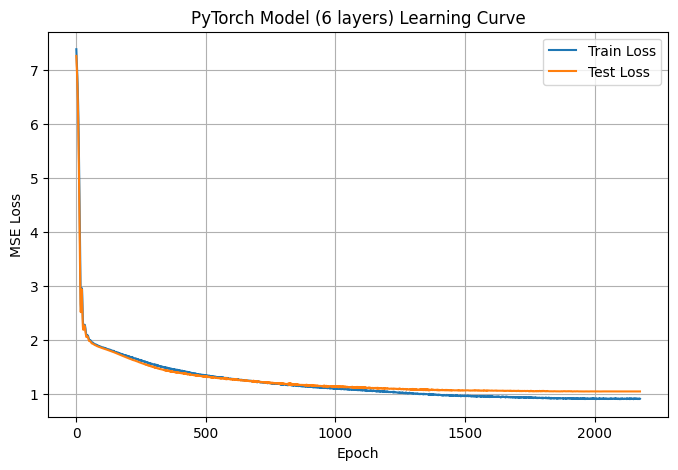

[PyTorch Model (6 layers) - Test Set]
MAE:  0.7663
RMSE: 1.0232
R²:   0.5663

[PyTorch Model (6 layers) - Training Set]
MAE:  0.6666
RMSE: 0.8666
R²:   0.6895


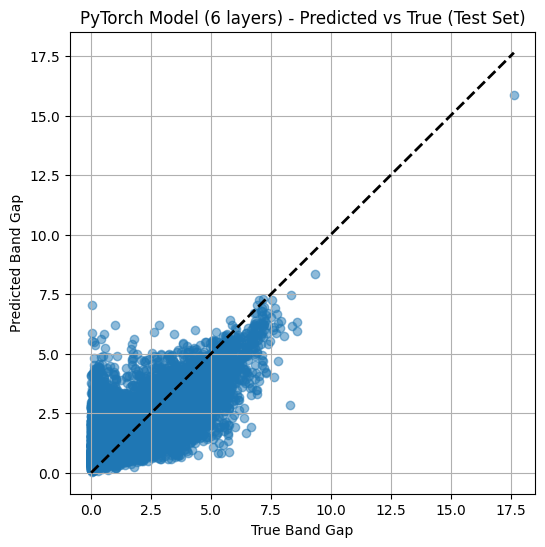

In [137]:
# Make a metrics dictionary
model_layers6_metrics = evaluate_model(
    model_layers6,
    X_train_tensor,
    y_train,
    X_test_tensor,
    y_test
)
# Analyze the model
analyze_model(
    model_layers6_metrics,
    y_test,
    train_losses_layers6,
    test_losses_layers6,
    model_name="PyTorch Model (6 layers)"
)

## 8 Layers Network

In [41]:
import torch.nn as nn

class DeepRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),  # Layer 1
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 384),        # Layer 2
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(384, 256),        # Layer 3
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 192),        # Layer 4
            nn.ReLU(),

            nn.Linear(192, 128),        # Layer 5
            nn.ReLU(),

            nn.Linear(128, 96),         # Layer 6
            nn.ReLU(),

            nn.Linear(96, 64),          # Layer 7
            nn.ReLU(),

            nn.Linear(64, 32),          # Layer 8
            nn.ReLU(),

            nn.Linear(32, 1)            # Output Layer
        )

    def forward(self, x):
        return self.net(x)

# Initialize the model with the input dimension (number of features)
model_layers8 = DeepRegressor(X_train_tensor.shape[1])

In [42]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal GPU on Mac
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU (not on Mac usually)
else:
    device = torch.device("cpu")  # Fallback

print("Using device:", device)

model_layers8.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print(X_train_tensor.device)
print(y_train_tensor.device)

Using device: cuda
cuda:0
cuda:0


In [43]:
model_layers8, train_losses_layers8, test_losses_layers8 = train_model(
    model_layers8,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    n_epochs=5000,
    lr=0.001,
    weight_decay=0,
    early_stop_patience=200,
    scheduler_patience=50,
    scheduler_factor=0.5,
    verbose_every=20
)

Training:   0%|          | 3/5000 [00:00<02:47, 29.81it/s]

Epoch    0 | Train Loss: 6.4979 | Test Loss: 6.4319


Training:   0%|          | 24/5000 [00:00<02:53, 28.65it/s]

Epoch   20 | Train Loss: 2.2178 | Test Loss: 2.1382


Training:   1%|          | 45/5000 [00:01<02:55, 28.21it/s]

Epoch   40 | Train Loss: 2.0038 | Test Loss: 1.9859


Training:   1%|▏         | 66/5000 [00:02<02:57, 27.87it/s]

Epoch   60 | Train Loss: 1.8832 | Test Loss: 1.8685


Training:   2%|▏         | 84/5000 [00:02<02:57, 27.63it/s]

Epoch   80 | Train Loss: 1.8231 | Test Loss: 1.8026


Training:   2%|▏         | 105/5000 [00:03<02:54, 28.10it/s]

Epoch  100 | Train Loss: 1.7711 | Test Loss: 1.7434


Training:   3%|▎         | 126/5000 [00:04<02:53, 28.03it/s]

Epoch  120 | Train Loss: 1.7162 | Test Loss: 1.6814


Training:   3%|▎         | 144/5000 [00:05<02:56, 27.54it/s]

Epoch  140 | Train Loss: 1.6681 | Test Loss: 1.6233


Training:   3%|▎         | 165/5000 [00:05<02:53, 27.84it/s]

Epoch  160 | Train Loss: 1.6295 | Test Loss: 1.5792


Training:   4%|▎         | 186/5000 [00:06<02:51, 28.05it/s]

Epoch  180 | Train Loss: 1.5858 | Test Loss: 1.5365


Training:   4%|▍         | 204/5000 [00:07<02:51, 27.97it/s]

Epoch  200 | Train Loss: 1.5527 | Test Loss: 1.5101


Training:   4%|▍         | 225/5000 [00:08<02:52, 27.72it/s]

Epoch  220 | Train Loss: 1.5171 | Test Loss: 1.4739


Training:   5%|▍         | 246/5000 [00:08<02:49, 28.10it/s]

Epoch  240 | Train Loss: 1.4897 | Test Loss: 1.4360


Training:   5%|▌         | 264/5000 [00:09<02:48, 28.10it/s]

Epoch  260 | Train Loss: 1.4560 | Test Loss: 1.4183


Training:   6%|▌         | 285/5000 [00:10<02:48, 28.03it/s]

Epoch  280 | Train Loss: 1.4244 | Test Loss: 1.4128


Training:   6%|▌         | 306/5000 [00:10<02:48, 27.91it/s]

Epoch  300 | Train Loss: 1.4093 | Test Loss: 1.3829


Training:   6%|▋         | 324/5000 [00:11<02:46, 28.08it/s]

Epoch  320 | Train Loss: 1.3880 | Test Loss: 1.3587


Training:   7%|▋         | 345/5000 [00:12<02:46, 27.89it/s]

Epoch  340 | Train Loss: 1.3729 | Test Loss: 1.3377


Training:   7%|▋         | 366/5000 [00:13<02:46, 27.85it/s]

Epoch  360 | Train Loss: 1.3520 | Test Loss: 1.3513


Training:   8%|▊         | 384/5000 [00:13<02:45, 27.94it/s]

Epoch  380 | Train Loss: 1.3302 | Test Loss: 1.3229


Training:   8%|▊         | 405/5000 [00:14<02:44, 27.99it/s]

Epoch  400 | Train Loss: 1.3196 | Test Loss: 1.3445


Training:   9%|▊         | 426/5000 [00:15<02:43, 28.04it/s]

Epoch  420 | Train Loss: 1.2960 | Test Loss: 1.3178


Training:   9%|▉         | 444/5000 [00:15<02:43, 27.83it/s]

Epoch  440 | Train Loss: 1.2791 | Test Loss: 1.3009


Training:   9%|▉         | 465/5000 [00:16<02:42, 27.97it/s]

Epoch  460 | Train Loss: 1.2691 | Test Loss: 1.3173


Training:  10%|▉         | 486/5000 [00:17<02:41, 27.95it/s]

Epoch  480 | Train Loss: 1.2538 | Test Loss: 1.3378


Training:  10%|█         | 504/5000 [00:18<02:40, 27.94it/s]

Epoch  500 | Train Loss: 1.2403 | Test Loss: 1.2901


Training:  10%|█         | 525/5000 [00:18<02:40, 27.88it/s]

Epoch  520 | Train Loss: 1.2205 | Test Loss: 1.2878


Training:  11%|█         | 546/5000 [00:19<02:39, 28.01it/s]

Epoch  540 | Train Loss: 1.2105 | Test Loss: 1.2804


Training:  11%|█▏        | 564/5000 [00:20<02:38, 28.08it/s]

Epoch  560 | Train Loss: 1.1975 | Test Loss: 1.2422


Training:  12%|█▏        | 585/5000 [00:20<02:37, 27.95it/s]

Epoch  580 | Train Loss: 1.1743 | Test Loss: 1.2366


Training:  12%|█▏        | 606/5000 [00:21<02:37, 27.88it/s]

Epoch  600 | Train Loss: 1.1621 | Test Loss: 1.2591


Training:  12%|█▏        | 624/5000 [00:22<02:36, 27.99it/s]

Epoch  620 | Train Loss: 1.1528 | Test Loss: 1.2315


Training:  13%|█▎        | 645/5000 [00:23<02:36, 27.80it/s]

Epoch  640 | Train Loss: 1.1353 | Test Loss: 1.2261


Training:  13%|█▎        | 666/5000 [00:23<02:35, 27.95it/s]

Epoch  660 | Train Loss: 1.1239 | Test Loss: 1.2141


Training:  14%|█▎        | 684/5000 [00:24<02:33, 28.12it/s]

Epoch  680 | Train Loss: 1.1075 | Test Loss: 1.2034


Training:  14%|█▍        | 705/5000 [00:25<02:33, 28.04it/s]

Epoch  700 | Train Loss: 1.0892 | Test Loss: 1.1781


Training:  15%|█▍        | 726/5000 [00:25<02:32, 28.03it/s]

Epoch  720 | Train Loss: 1.0783 | Test Loss: 1.2220


Training:  15%|█▍        | 744/5000 [00:26<02:31, 28.10it/s]

Epoch  740 | Train Loss: 1.0634 | Test Loss: 1.2264


Training:  15%|█▌        | 765/5000 [00:27<02:30, 28.18it/s]

Epoch  760 | Train Loss: 1.0460 | Test Loss: 1.2055


Training:  16%|█▌        | 786/5000 [00:28<02:30, 28.08it/s]

Epoch  780 | Train Loss: 1.0277 | Test Loss: 1.1886


Training:  16%|█▌        | 804/5000 [00:28<02:30, 27.96it/s]

Epoch  800 | Train Loss: 1.0257 | Test Loss: 1.2239


Training:  16%|█▋        | 825/5000 [00:29<02:28, 28.09it/s]

Epoch  820 | Train Loss: 1.0086 | Test Loss: 1.1289


Training:  17%|█▋        | 846/5000 [00:30<02:28, 28.01it/s]

Epoch  840 | Train Loss: 0.9993 | Test Loss: 1.1513


Training:  17%|█▋        | 864/5000 [00:30<02:27, 28.00it/s]

Epoch  860 | Train Loss: 0.9835 | Test Loss: 1.1277


Training:  18%|█▊        | 885/5000 [00:31<02:26, 28.08it/s]

Epoch  880 | Train Loss: 0.9646 | Test Loss: 1.1286


Training:  18%|█▊        | 906/5000 [00:32<02:25, 28.15it/s]

Epoch  900 | Train Loss: 0.9584 | Test Loss: 1.1543


Training:  18%|█▊        | 924/5000 [00:33<02:25, 28.02it/s]

Epoch  920 | Train Loss: 0.9414 | Test Loss: 1.1114


Training:  19%|█▉        | 945/5000 [00:33<02:24, 28.06it/s]

Epoch  940 | Train Loss: 0.9280 | Test Loss: 1.1374


Training:  19%|█▉        | 966/5000 [00:34<02:23, 28.09it/s]

Epoch  960 | Train Loss: 0.9124 | Test Loss: 1.1021


Training:  20%|█▉        | 984/5000 [00:35<02:22, 28.11it/s]

Epoch  980 | Train Loss: 0.9011 | Test Loss: 1.0840


Training:  20%|██        | 1005/5000 [00:35<02:23, 27.81it/s]

Epoch 1000 | Train Loss: 0.8896 | Test Loss: 1.1195


Training:  21%|██        | 1026/5000 [00:36<02:22, 27.94it/s]

Epoch 1020 | Train Loss: 0.8768 | Test Loss: 1.0646


Training:  21%|██        | 1044/5000 [00:37<02:20, 28.20it/s]

Epoch 1040 | Train Loss: 0.8553 | Test Loss: 1.0674


Training:  21%|██▏       | 1065/5000 [00:38<02:20, 27.97it/s]

Epoch 1060 | Train Loss: 0.8501 | Test Loss: 1.0671


Training:  22%|██▏       | 1086/5000 [00:38<02:20, 27.91it/s]

Epoch 1080 | Train Loss: 0.8418 | Test Loss: 1.0601


Training:  22%|██▏       | 1104/5000 [00:39<02:18, 28.08it/s]

Epoch 1100 | Train Loss: 0.8315 | Test Loss: 1.0549


Training:  22%|██▎       | 1125/5000 [00:40<02:17, 28.08it/s]

Epoch 1120 | Train Loss: 0.8249 | Test Loss: 1.0651


Training:  23%|██▎       | 1146/5000 [00:40<02:18, 27.84it/s]

Epoch 1140 | Train Loss: 0.8200 | Test Loss: 1.0678


Training:  23%|██▎       | 1164/5000 [00:41<02:17, 27.96it/s]

Epoch 1160 | Train Loss: 0.8212 | Test Loss: 1.0648


Training:  24%|██▎       | 1185/5000 [00:42<02:15, 28.15it/s]

Epoch 1180 | Train Loss: 0.8081 | Test Loss: 1.0625


Training:  24%|██▍       | 1204/5000 [00:43<02:15, 27.96it/s]

Epoch 1200 | Train Loss: 0.8122 | Test Loss: 1.0557

⏹️ Early stopping at epoch 1204

✅ Training completed in 43.06 seconds (0.72 minutes)


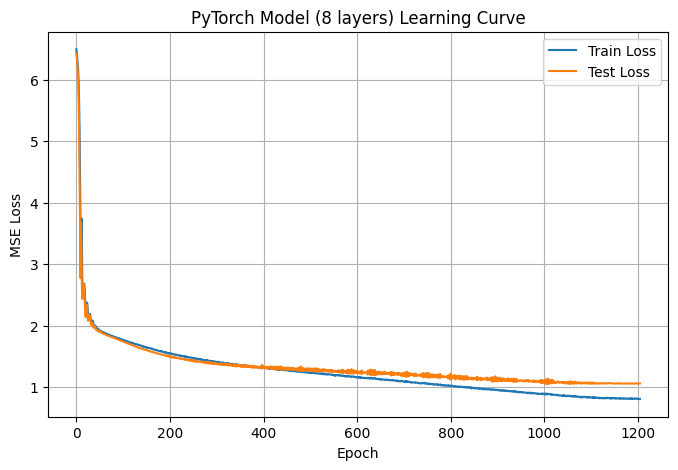

[PyTorch Model (8 layers) - Test Set]
MAE:  0.7613
RMSE: 1.0302
R²:   0.5603

[PyTorch Model (8 layers) - Training Set]
MAE:  0.6171
RMSE: 0.8005
R²:   0.7350


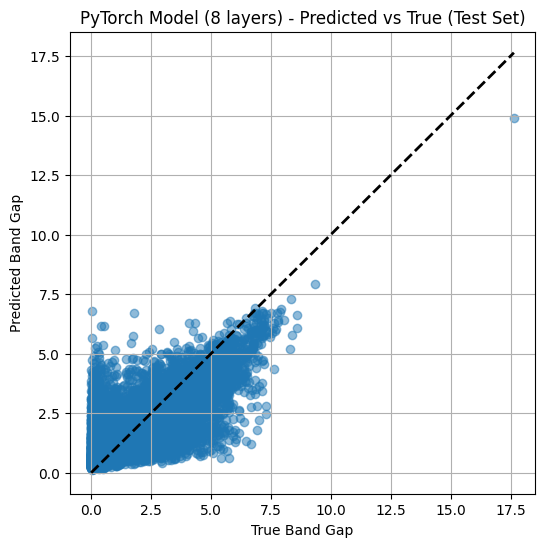

In [44]:
# Evaluate model
# Make a metrics dictionary
model_layers8_metrics = evaluate_model(
    model_layers8,
    X_train_tensor,
    y_train,
    X_test_tensor,
    y_test
)
# Analyze the model
analyze_model(
    model_layers8_metrics,
    y_test,
    train_losses_layers8,
    test_losses_layers8,
    model_name="PyTorch Model (8 layers)"
)

## 10 Layers Network

In [139]:
import torch.nn as nn

class DeepRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),  # Layer 1
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 384),        # Layer 2
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(384, 256),        # Layer 3
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 192),        # Layer 4
            nn.ReLU(),

            nn.Linear(192, 128),        # Layer 5
            nn.ReLU(),

            nn.Linear(128, 96),         # Layer 6
            nn.ReLU(),

            nn.Linear(96, 64),          # Layer 7
            nn.ReLU(),

            nn.Linear(64, 48),          # Layer 8
            nn.ReLU(),

            nn.Linear(48, 32),          # Layer 9
            nn.ReLU(),

            nn.Linear(32, 1)            # Layer 10 (Output)
        )

    def forward(self, x):
        return self.net(x)

# Initialize the model
model_layers10 = DeepRegressor(X_train_tensor.shape[1])


In [140]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal GPU on Mac
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU (not on Mac usually)
else:
    device = torch.device("cpu")  # Fallback

print("Using device:", device)

model_layers10.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print(X_train_tensor.device)
print(y_train_tensor.device)

Using device: cuda
cuda:0
cuda:0


In [141]:
model_layers10, train_losses_layers10, test_losses_layers10 = train_model(
    model_layers10,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    n_epochs=5000,
    lr=0.001,
    weight_decay=0,
    early_stop_patience=200,
    scheduler_patience=50,
    scheduler_factor=0.5,
    verbose_every=20
)

Training:   0%|          | 6/5000 [00:00<02:51, 29.05it/s]

Epoch    0 | Train Loss: 6.4433 | Test Loss: 6.3793


Training:   0%|          | 24/5000 [00:00<02:54, 28.52it/s]

Epoch   20 | Train Loss: 2.4095 | Test Loss: 2.2265


Training:   1%|          | 45/5000 [00:01<02:55, 28.16it/s]

Epoch   40 | Train Loss: 2.0173 | Test Loss: 2.0068


Training:   1%|▏         | 66/5000 [00:02<02:56, 27.97it/s]

Epoch   60 | Train Loss: 1.8912 | Test Loss: 1.8828


Training:   2%|▏         | 84/5000 [00:02<02:56, 27.91it/s]

Epoch   80 | Train Loss: 1.8420 | Test Loss: 1.8226


Training:   2%|▏         | 105/5000 [00:03<02:55, 27.94it/s]

Epoch  100 | Train Loss: 1.7908 | Test Loss: 1.7754


Training:   3%|▎         | 126/5000 [00:04<02:54, 27.89it/s]

Epoch  120 | Train Loss: 1.7433 | Test Loss: 1.7200


Training:   3%|▎         | 144/5000 [00:05<02:55, 27.71it/s]

Epoch  140 | Train Loss: 1.6864 | Test Loss: 1.6494


Training:   3%|▎         | 165/5000 [00:05<02:53, 27.79it/s]

Epoch  160 | Train Loss: 1.6258 | Test Loss: 1.5760


Training:   4%|▎         | 186/5000 [00:06<02:53, 27.81it/s]

Epoch  180 | Train Loss: 1.5803 | Test Loss: 1.5311


Training:   4%|▍         | 204/5000 [00:07<02:53, 27.59it/s]

Epoch  200 | Train Loss: 1.5416 | Test Loss: 1.4960


Training:   4%|▍         | 225/5000 [00:08<02:52, 27.73it/s]

Epoch  220 | Train Loss: 1.4974 | Test Loss: 1.4731


Training:   5%|▍         | 246/5000 [00:08<02:50, 27.90it/s]

Epoch  240 | Train Loss: 1.4785 | Test Loss: 1.4462


Training:   5%|▌         | 264/5000 [00:09<02:50, 27.74it/s]

Epoch  260 | Train Loss: 1.4490 | Test Loss: 1.4147


Training:   6%|▌         | 285/5000 [00:10<02:49, 27.74it/s]

Epoch  280 | Train Loss: 1.4192 | Test Loss: 1.4187


Training:   6%|▌         | 306/5000 [00:10<02:48, 27.82it/s]

Epoch  300 | Train Loss: 1.3958 | Test Loss: 1.3727


Training:   6%|▋         | 324/5000 [00:11<02:48, 27.78it/s]

Epoch  320 | Train Loss: 1.3692 | Test Loss: 1.3693


Training:   7%|▋         | 345/5000 [00:12<02:48, 27.57it/s]

Epoch  340 | Train Loss: 1.3538 | Test Loss: 1.3427


Training:   7%|▋         | 366/5000 [00:13<02:46, 27.83it/s]

Epoch  360 | Train Loss: 1.3345 | Test Loss: 1.3147


Training:   8%|▊         | 384/5000 [00:13<02:45, 27.91it/s]

Epoch  380 | Train Loss: 1.3149 | Test Loss: 1.3099


Training:   8%|▊         | 405/5000 [00:14<02:45, 27.77it/s]

Epoch  400 | Train Loss: 1.2996 | Test Loss: 1.3017


Training:   9%|▊         | 426/5000 [00:15<02:44, 27.74it/s]

Epoch  420 | Train Loss: 1.2738 | Test Loss: 1.2995


Training:   9%|▉         | 444/5000 [00:15<02:43, 27.82it/s]

Epoch  440 | Train Loss: 1.2552 | Test Loss: 1.2981


Training:   9%|▉         | 465/5000 [00:16<02:43, 27.80it/s]

Epoch  460 | Train Loss: 1.2418 | Test Loss: 1.2913


Training:  10%|▉         | 486/5000 [00:17<02:42, 27.78it/s]

Epoch  480 | Train Loss: 1.2235 | Test Loss: 1.2875


Training:  10%|█         | 504/5000 [00:18<02:41, 27.77it/s]

Epoch  500 | Train Loss: 1.2146 | Test Loss: 1.2395


Training:  10%|█         | 525/5000 [00:18<02:41, 27.78it/s]

Epoch  520 | Train Loss: 1.1880 | Test Loss: 1.2363


Training:  11%|█         | 546/5000 [00:19<02:39, 27.88it/s]

Epoch  540 | Train Loss: 1.1669 | Test Loss: 1.2298


Training:  11%|█▏        | 564/5000 [00:20<02:39, 27.89it/s]

Epoch  560 | Train Loss: 1.1580 | Test Loss: 1.2251


Training:  12%|█▏        | 585/5000 [00:20<02:38, 27.82it/s]

Epoch  580 | Train Loss: 1.1380 | Test Loss: 1.2060


Training:  12%|█▏        | 606/5000 [00:21<02:37, 27.90it/s]

Epoch  600 | Train Loss: 1.1145 | Test Loss: 1.2101


Training:  12%|█▏        | 624/5000 [00:22<02:37, 27.86it/s]

Epoch  620 | Train Loss: 1.1068 | Test Loss: 1.2421


Training:  13%|█▎        | 645/5000 [00:23<02:35, 27.96it/s]

Epoch  640 | Train Loss: 1.0845 | Test Loss: 1.1622


Training:  13%|█▎        | 666/5000 [00:23<02:35, 27.79it/s]

Epoch  660 | Train Loss: 1.0691 | Test Loss: 1.2011


Training:  14%|█▎        | 684/5000 [00:24<02:35, 27.77it/s]

Epoch  680 | Train Loss: 1.0563 | Test Loss: 1.1574


Training:  14%|█▍        | 705/5000 [00:25<02:33, 27.89it/s]

Epoch  700 | Train Loss: 1.0387 | Test Loss: 1.1408


Training:  15%|█▍        | 726/5000 [00:26<02:33, 27.82it/s]

Epoch  720 | Train Loss: 1.0133 | Test Loss: 1.1476


Training:  15%|█▍        | 744/5000 [00:26<02:32, 27.95it/s]

Epoch  740 | Train Loss: 1.0131 | Test Loss: 1.1163


Training:  15%|█▌        | 765/5000 [00:27<02:31, 27.90it/s]

Epoch  760 | Train Loss: 0.9979 | Test Loss: 1.1034


Training:  16%|█▌        | 786/5000 [00:28<02:30, 27.94it/s]

Epoch  780 | Train Loss: 0.9709 | Test Loss: 1.0866


Training:  16%|█▌        | 804/5000 [00:28<02:30, 27.90it/s]

Epoch  800 | Train Loss: 0.9672 | Test Loss: 1.0935


Training:  16%|█▋        | 825/5000 [00:29<02:30, 27.75it/s]

Epoch  820 | Train Loss: 0.9541 | Test Loss: 1.0987


Training:  17%|█▋        | 846/5000 [00:30<02:28, 27.93it/s]

Epoch  840 | Train Loss: 0.9253 | Test Loss: 1.0867


Training:  17%|█▋        | 864/5000 [00:31<02:28, 27.76it/s]

Epoch  860 | Train Loss: 0.9180 | Test Loss: 1.0722


Training:  18%|█▊        | 885/5000 [00:31<02:27, 27.90it/s]

Epoch  880 | Train Loss: 0.9169 | Test Loss: 1.0730


Training:  18%|█▊        | 906/5000 [00:32<02:27, 27.84it/s]

Epoch  900 | Train Loss: 0.8931 | Test Loss: 1.0620


Training:  18%|█▊        | 924/5000 [00:33<02:26, 27.87it/s]

Epoch  920 | Train Loss: 0.8849 | Test Loss: 1.0670


Training:  19%|█▉        | 945/5000 [00:33<02:25, 27.91it/s]

Epoch  940 | Train Loss: 0.8687 | Test Loss: 1.0555


Training:  19%|█▉        | 966/5000 [00:34<02:24, 27.87it/s]

Epoch  960 | Train Loss: 0.8598 | Test Loss: 1.0581


Training:  20%|█▉        | 984/5000 [00:35<02:24, 27.83it/s]

Epoch  980 | Train Loss: 0.8475 | Test Loss: 1.0389


Training:  20%|██        | 1005/5000 [00:36<02:23, 27.91it/s]

Epoch 1000 | Train Loss: 0.8323 | Test Loss: 1.0461


Training:  21%|██        | 1026/5000 [00:36<02:22, 27.87it/s]

Epoch 1020 | Train Loss: 0.8272 | Test Loss: 1.0514


Training:  21%|██        | 1044/5000 [00:37<02:22, 27.73it/s]

Epoch 1040 | Train Loss: 0.8194 | Test Loss: 1.0382


Training:  21%|██▏       | 1065/5000 [00:38<02:21, 27.78it/s]

Epoch 1060 | Train Loss: 0.8102 | Test Loss: 1.0296


Training:  22%|██▏       | 1086/5000 [00:38<02:21, 27.73it/s]

Epoch 1080 | Train Loss: 0.8025 | Test Loss: 1.0338


Training:  22%|██▏       | 1104/5000 [00:39<02:19, 27.86it/s]

Epoch 1100 | Train Loss: 0.7913 | Test Loss: 1.0076


Training:  22%|██▎       | 1125/5000 [00:40<02:18, 27.89it/s]

Epoch 1120 | Train Loss: 0.7885 | Test Loss: 1.0215


Training:  23%|██▎       | 1146/5000 [00:41<02:18, 27.80it/s]

Epoch 1140 | Train Loss: 0.7704 | Test Loss: 1.0292


Training:  23%|██▎       | 1164/5000 [00:41<02:18, 27.73it/s]

Epoch 1160 | Train Loss: 0.7633 | Test Loss: 1.0181


Training:  24%|██▎       | 1185/5000 [00:42<02:16, 27.91it/s]

Epoch 1180 | Train Loss: 0.7583 | Test Loss: 1.0075


Training:  24%|██▍       | 1206/5000 [00:43<02:16, 27.89it/s]

Epoch 1200 | Train Loss: 0.7516 | Test Loss: 1.0069


Training:  24%|██▍       | 1224/5000 [00:43<02:16, 27.70it/s]

Epoch 1220 | Train Loss: 0.7407 | Test Loss: 0.9983


Training:  25%|██▍       | 1245/5000 [00:44<02:14, 27.93it/s]

Epoch 1240 | Train Loss: 0.7369 | Test Loss: 1.0116


Training:  25%|██▌       | 1266/5000 [00:45<02:14, 27.74it/s]

Epoch 1260 | Train Loss: 0.7243 | Test Loss: 0.9915


Training:  26%|██▌       | 1284/5000 [00:46<02:13, 27.83it/s]

Epoch 1280 | Train Loss: 0.7304 | Test Loss: 0.9947


Training:  26%|██▌       | 1305/5000 [00:46<02:13, 27.78it/s]

Epoch 1300 | Train Loss: 0.7105 | Test Loss: 0.9976


Training:  27%|██▋       | 1326/5000 [00:47<02:12, 27.77it/s]

Epoch 1320 | Train Loss: 0.7046 | Test Loss: 1.0004


Training:  27%|██▋       | 1344/5000 [00:48<02:11, 27.86it/s]

Epoch 1340 | Train Loss: 0.6949 | Test Loss: 0.9897


Training:  27%|██▋       | 1365/5000 [00:49<02:10, 27.84it/s]

Epoch 1360 | Train Loss: 0.6906 | Test Loss: 0.9952


Training:  28%|██▊       | 1386/5000 [00:49<02:10, 27.65it/s]

Epoch 1380 | Train Loss: 0.6878 | Test Loss: 0.9902


Training:  28%|██▊       | 1404/5000 [00:50<02:08, 27.89it/s]

Epoch 1400 | Train Loss: 0.6881 | Test Loss: 0.9893


Training:  28%|██▊       | 1425/5000 [00:51<02:08, 27.81it/s]

Epoch 1420 | Train Loss: 0.6833 | Test Loss: 0.9903


Training:  29%|██▉       | 1446/5000 [00:51<02:07, 27.82it/s]

Epoch 1440 | Train Loss: 0.6848 | Test Loss: 0.9879


Training:  29%|██▉       | 1464/5000 [00:52<02:06, 27.88it/s]

Epoch 1460 | Train Loss: 0.6747 | Test Loss: 0.9859


Training:  30%|██▉       | 1485/5000 [00:53<02:06, 27.87it/s]

Epoch 1480 | Train Loss: 0.6772 | Test Loss: 0.9915


Training:  30%|███       | 1506/5000 [00:54<02:05, 27.80it/s]

Epoch 1500 | Train Loss: 0.6778 | Test Loss: 0.9878


Training:  30%|███       | 1524/5000 [00:54<02:05, 27.74it/s]

Epoch 1520 | Train Loss: 0.6761 | Test Loss: 0.9858


Training:  31%|███       | 1545/5000 [00:55<02:03, 27.87it/s]

Epoch 1540 | Train Loss: 0.6815 | Test Loss: 0.9860


Training:  31%|███▏      | 1566/5000 [00:56<02:03, 27.86it/s]

Epoch 1560 | Train Loss: 0.6718 | Test Loss: 0.9854


Training:  32%|███▏      | 1584/5000 [00:56<02:02, 27.83it/s]

Epoch 1580 | Train Loss: 0.6668 | Test Loss: 0.9858


Training:  32%|███▏      | 1604/5000 [00:57<02:02, 27.82it/s]

Epoch 1600 | Train Loss: 0.6740 | Test Loss: 0.9858

⏹️ Early stopping at epoch 1604

✅ Training completed in 57.66 seconds (0.96 minutes)


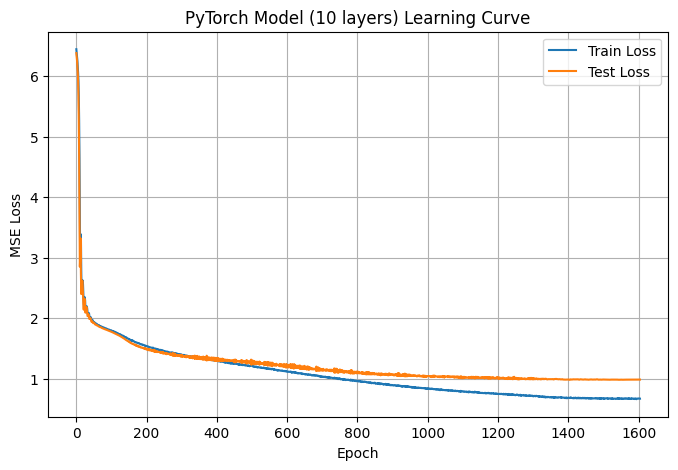

[PyTorch Model (10 layers) - Test Set]
MAE:  0.7134
RMSE: 0.9935
R²:   0.5911

[PyTorch Model (10 layers) - Training Set]
MAE:  0.5119
RMSE: 0.6714
R²:   0.8136


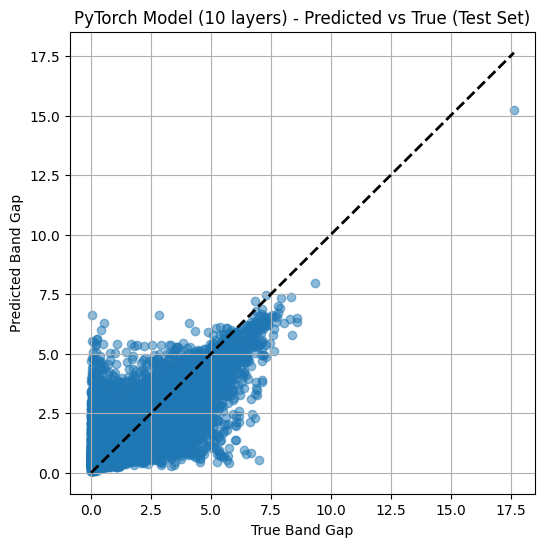

In [142]:
# Evaluate model
# Make a metrics dictionary
model_layers10_metrics = evaluate_model(
    model_layers10,
    X_train_tensor,
    y_train,
    X_test_tensor,
    y_test
)
# Analyze the model
analyze_model(
    model_layers10_metrics,
    y_test,
    train_losses_layers10,
    test_losses_layers10,
    model_name="PyTorch Model (10 layers)"
)


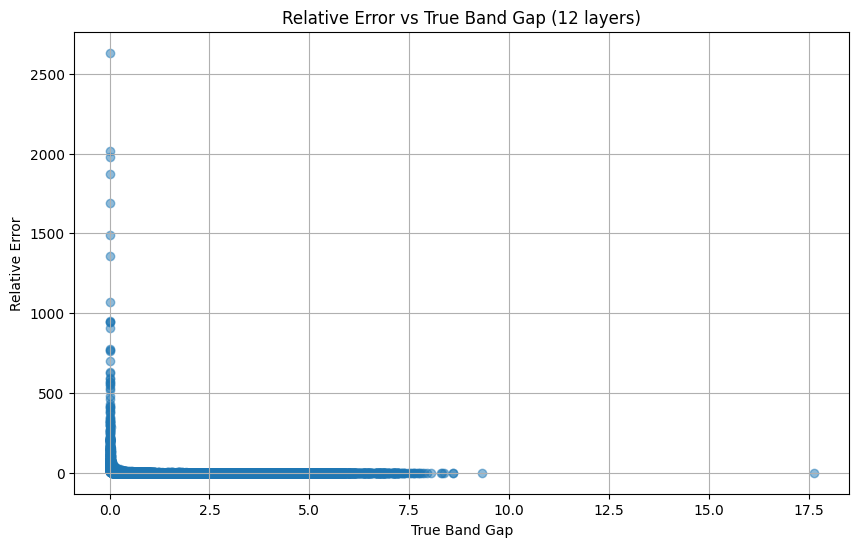

In [49]:
# relative error vs true band gap plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, np.abs(model_layers10_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5)
plt.xlabel("True Band Gap")
plt.ylabel("Relative Error")
plt.title("Relative Error vs True Band Gap (12 layers)")
plt.grid(True)
plt.show()

## 12 Layers Network

In [69]:
import torch.nn as nn

class DeepRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 768),   # Layer 1
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(768, 512),         # Layer 2
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 384),         # Layer 3
            nn.ReLU(),

            nn.Linear(384, 256),         # Layer 4
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 192),         # Layer 5
            nn.ReLU(),

            nn.Linear(192, 128),         # Layer 6
            nn.ReLU(),

            nn.Linear(128, 96),          # Layer 7
            nn.ReLU(),

            nn.Linear(96, 72),           # Layer 8
            nn.ReLU(),

            nn.Linear(72, 48),           # Layer 9
            nn.ReLU(),

            nn.Linear(48, 32),           # Layer 10
            nn.ReLU(),

            nn.Linear(32, 16),           # Layer 11
            nn.ReLU(),

            nn.Linear(16, 1)             # Layer 12 (Output)
        )

    def forward(self, x):
        return self.net(x)

# Initialize the 12-layer model
model_layers12 = DeepRegressor(X_train_tensor.shape[1])


In [70]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal GPU on Mac
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU (not on Mac usually)
else:
    device = torch.device("cpu")  # Fallback

print("Using device:", device)

model_layers12.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print(X_train_tensor.device)
print(y_train_tensor.device)

Using device: cuda
cuda:0
cuda:0


In [71]:
model_layers12, train_losses_layers12, test_losses_layers12 = train_model(
    model_layers12,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    n_epochs=5000,
    lr=0.001,
    weight_decay=0, # L2 regularization
    early_stop_patience=200,
    scheduler_patience=50,
    scheduler_factor=0.5,
    verbose_every=20
)

Training:   0%|          | 4/5000 [00:00<04:43, 17.65it/s]

Epoch    0 | Train Loss: 7.4971 | Test Loss: 7.4584


Training:   0%|          | 24/5000 [00:01<04:53, 16.96it/s]

Epoch   20 | Train Loss: 2.5580 | Test Loss: 2.2823


Training:   1%|          | 44/5000 [00:02<04:47, 17.23it/s]

Epoch   40 | Train Loss: 2.0484 | Test Loss: 2.0005


Training:   1%|▏         | 64/5000 [00:03<04:46, 17.22it/s]

Epoch   60 | Train Loss: 1.9288 | Test Loss: 1.9116


Training:   2%|▏         | 84/5000 [00:04<04:45, 17.22it/s]

Epoch   80 | Train Loss: 1.8623 | Test Loss: 1.8465


Training:   2%|▏         | 104/5000 [00:06<04:47, 17.04it/s]

Epoch  100 | Train Loss: 1.8053 | Test Loss: 1.7865


Training:   2%|▏         | 124/5000 [00:07<04:47, 16.98it/s]

Epoch  120 | Train Loss: 1.7520 | Test Loss: 1.7235


Training:   3%|▎         | 144/5000 [00:08<04:47, 16.88it/s]

Epoch  140 | Train Loss: 1.6890 | Test Loss: 1.6552


Training:   3%|▎         | 164/5000 [00:09<04:45, 16.92it/s]

Epoch  160 | Train Loss: 1.6381 | Test Loss: 1.6010


Training:   4%|▎         | 184/5000 [00:10<04:45, 16.88it/s]

Epoch  180 | Train Loss: 1.5938 | Test Loss: 1.5491


Training:   4%|▍         | 204/5000 [00:11<04:41, 17.05it/s]

Epoch  200 | Train Loss: 1.5630 | Test Loss: 1.5150


Training:   4%|▍         | 224/5000 [00:13<04:46, 16.69it/s]

Epoch  220 | Train Loss: 1.5201 | Test Loss: 1.4770


Training:   5%|▍         | 244/5000 [00:14<04:43, 16.79it/s]

Epoch  240 | Train Loss: 1.4944 | Test Loss: 1.4547


Training:   5%|▌         | 264/5000 [00:15<04:44, 16.65it/s]

Epoch  260 | Train Loss: 1.4589 | Test Loss: 1.4339


Training:   6%|▌         | 284/5000 [00:16<04:37, 17.00it/s]

Epoch  280 | Train Loss: 1.4342 | Test Loss: 1.4150


Training:   6%|▌         | 304/5000 [00:17<04:40, 16.76it/s]

Epoch  300 | Train Loss: 1.4139 | Test Loss: 1.3849


Training:   6%|▋         | 324/5000 [00:19<04:39, 16.74it/s]

Epoch  320 | Train Loss: 1.3928 | Test Loss: 1.3658


Training:   7%|▋         | 344/5000 [00:20<04:39, 16.66it/s]

Epoch  340 | Train Loss: 1.3746 | Test Loss: 1.3544


Training:   7%|▋         | 364/5000 [00:21<04:38, 16.66it/s]

Epoch  360 | Train Loss: 1.3528 | Test Loss: 1.3375


Training:   8%|▊         | 384/5000 [00:22<04:36, 16.69it/s]

Epoch  380 | Train Loss: 1.3391 | Test Loss: 1.3657


Training:   8%|▊         | 404/5000 [00:23<04:34, 16.73it/s]

Epoch  400 | Train Loss: 1.3248 | Test Loss: 1.3319


Training:   8%|▊         | 424/5000 [00:25<04:34, 16.66it/s]

Epoch  420 | Train Loss: 1.3041 | Test Loss: 1.3141


Training:   9%|▉         | 444/5000 [00:26<04:33, 16.67it/s]

Epoch  440 | Train Loss: 1.3084 | Test Loss: 1.2873


Training:   9%|▉         | 464/5000 [00:27<04:32, 16.67it/s]

Epoch  460 | Train Loss: 1.2858 | Test Loss: 1.3037


Training:  10%|▉         | 484/5000 [00:28<04:30, 16.71it/s]

Epoch  480 | Train Loss: 1.2802 | Test Loss: 1.2700


Training:  10%|█         | 504/5000 [00:29<04:29, 16.66it/s]

Epoch  500 | Train Loss: 1.2546 | Test Loss: 1.2784


Training:  10%|█         | 524/5000 [00:31<04:27, 16.72it/s]

Epoch  520 | Train Loss: 1.2419 | Test Loss: 1.2609


Training:  11%|█         | 544/5000 [00:32<04:27, 16.65it/s]

Epoch  540 | Train Loss: 1.2269 | Test Loss: 1.2473


Training:  11%|█▏        | 564/5000 [00:33<04:25, 16.73it/s]

Epoch  560 | Train Loss: 1.2052 | Test Loss: 1.3005


Training:  12%|█▏        | 584/5000 [00:34<04:25, 16.64it/s]

Epoch  580 | Train Loss: 1.1952 | Test Loss: 1.2554


Training:  12%|█▏        | 604/5000 [00:35<04:23, 16.68it/s]

Epoch  600 | Train Loss: 1.1852 | Test Loss: 1.2369


Training:  12%|█▏        | 624/5000 [00:37<04:21, 16.72it/s]

Epoch  620 | Train Loss: 1.1669 | Test Loss: 1.2574


Training:  13%|█▎        | 644/5000 [00:38<04:21, 16.66it/s]

Epoch  640 | Train Loss: 1.1579 | Test Loss: 1.2113


Training:  13%|█▎        | 664/5000 [00:39<04:19, 16.70it/s]

Epoch  660 | Train Loss: 1.1386 | Test Loss: 1.2275


Training:  14%|█▎        | 684/5000 [00:40<04:18, 16.68it/s]

Epoch  680 | Train Loss: 1.1338 | Test Loss: 1.2335


Training:  14%|█▍        | 704/5000 [00:41<04:17, 16.67it/s]

Epoch  700 | Train Loss: 1.1289 | Test Loss: 1.2348


Training:  14%|█▍        | 724/5000 [00:43<04:16, 16.64it/s]

Epoch  720 | Train Loss: 1.1233 | Test Loss: 1.2271


Training:  15%|█▍        | 744/5000 [00:44<04:15, 16.68it/s]

Epoch  740 | Train Loss: 1.1183 | Test Loss: 1.2274


Training:  15%|█▌        | 764/5000 [00:45<04:14, 16.66it/s]

Epoch  760 | Train Loss: 1.1169 | Test Loss: 1.2304


Training:  16%|█▌        | 784/5000 [00:46<04:13, 16.66it/s]

Epoch  780 | Train Loss: 1.1139 | Test Loss: 1.2269


Training:  16%|█▌        | 789/5000 [00:47<04:11, 16.75it/s]


⏹️ Early stopping at epoch 789

✅ Training completed in 47.09 seconds (0.78 minutes)


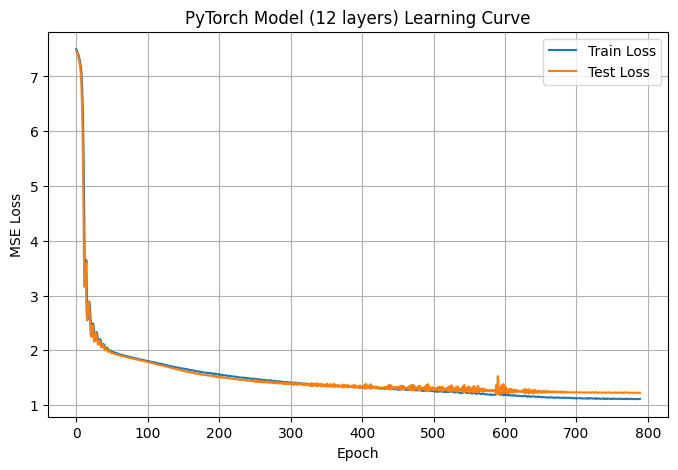

[PyTorch Model (12 layers) - Test Set]
MAE:  0.8464
RMSE: 1.1069
R²:   0.4924

[PyTorch Model (12 layers) - Training Set]
MAE:  0.7897
RMSE: 1.0196
R²:   0.5702


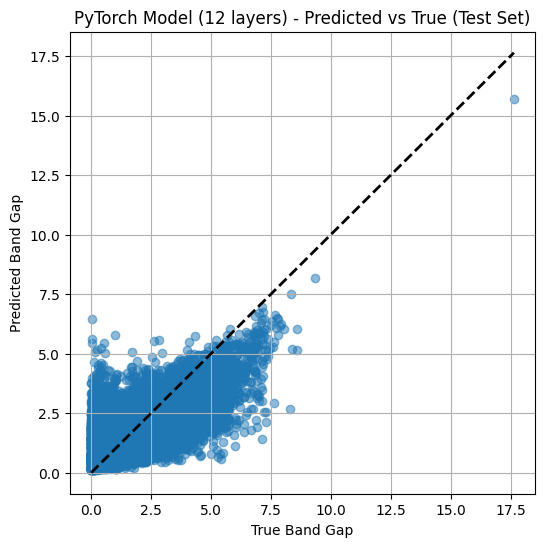

In [72]:
# Make a metrics dictionary
model_layers12_metrics = evaluate_model(
    model_layers12,
    X_train_tensor,
    y_train,
    X_test_tensor,
    y_test
)
# Analyze the model
analyze_model(
    model_layers12_metrics,
    y_test,
    train_losses_layers12,
    test_losses_layers12,
    model_name="PyTorch Model (12 layers)"
)

In [73]:
# shape of model_layers12_metrics['test']['y_pred_test']
print(model_layers12_metrics['test']['y_pred_test'].shape)
print(y_test.shape)

(16400, 1)
(16400,)


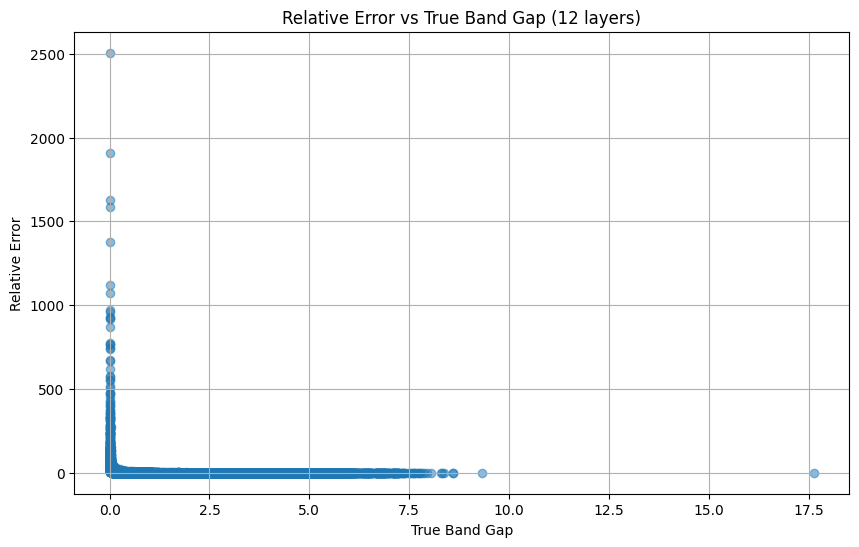

In [74]:
# relative error vs true band gap plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, np.abs(model_layers12_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5)
plt.xlabel("True Band Gap")
plt.ylabel("Relative Error")
plt.title("Relative Error vs True Band Gap (12 layers)")
plt.grid(True)
plt.show()

## 14 Layers Network

In [56]:
import torch.nn as nn

class DeepRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 768),   # Layer 1
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(768, 512),         # Layer 2
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 384),         # Layer 3
            nn.ReLU(),

            nn.Linear(384, 320),         # Layer 4
            nn.ReLU(),

            nn.Linear(320, 256),         # Layer 5
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 192),         # Layer 6
            nn.ReLU(),

            nn.Linear(192, 160),         # Layer 7
            nn.ReLU(),

            nn.Linear(160, 128),         # Layer 8
            nn.ReLU(),

            nn.Linear(128, 96),          # Layer 9
            nn.ReLU(),

            nn.Linear(96, 72),           # Layer 10
            nn.ReLU(),

            nn.Linear(72, 48),           # Layer 11
            nn.ReLU(),

            nn.Linear(48, 32),           # Layer 12
            nn.ReLU(),

            nn.Linear(32, 16),           # Layer 13
            nn.ReLU(),

            nn.Linear(16, 1)             # Layer 14 (Output)
        )

    def forward(self, x):
        return self.net(x)

# Initialize the 14-layer model
model_layers14 = DeepRegressor(X_train_tensor.shape[1])

In [57]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal GPU on Mac
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU (not on Mac usually)
else:
    device = torch.device("cpu")  # Fallback

print("Using device:", device)



model_layers14.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print(X_train_tensor.device)
print(y_train_tensor.device)

Using device: cuda
cuda:0
cuda:0


In [58]:
model_layers14, train_losses_layers14, test_losses_layers14 = train_model(
    model_layers14,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    n_epochs=5000,
    lr=0.001,
    weight_decay=0, # L2 regularization
    early_stop_patience=200,
    scheduler_patience=50,
    scheduler_factor=0.5,
    verbose_every=20
)

Training:   0%|          | 2/5000 [00:00<05:35, 14.88it/s]

Epoch    0 | Train Loss: 7.1763 | Test Loss: 7.1427


Training:   0%|          | 22/5000 [00:01<06:12, 13.37it/s]

Epoch   20 | Train Loss: 3.3972 | Test Loss: 2.9114


Training:   1%|          | 42/5000 [00:03<06:18, 13.09it/s]

Epoch   40 | Train Loss: 2.1828 | Test Loss: 2.1532


Training:   1%|          | 62/5000 [00:04<06:11, 13.29it/s]

Epoch   60 | Train Loss: 1.9751 | Test Loss: 1.9535


Training:   2%|▏         | 82/5000 [00:06<06:14, 13.12it/s]

Epoch   80 | Train Loss: 1.8918 | Test Loss: 1.8817


Training:   2%|▏         | 102/5000 [00:07<06:10, 13.21it/s]

Epoch  100 | Train Loss: 1.8380 | Test Loss: 1.8281


Training:   2%|▏         | 122/5000 [00:09<06:08, 13.23it/s]

Epoch  120 | Train Loss: 1.7895 | Test Loss: 1.7751


Training:   3%|▎         | 142/5000 [00:10<06:06, 13.25it/s]

Epoch  140 | Train Loss: 1.7477 | Test Loss: 1.7251


Training:   3%|▎         | 162/5000 [00:12<06:08, 13.12it/s]

Epoch  160 | Train Loss: 1.7084 | Test Loss: 1.6785


Training:   4%|▎         | 182/5000 [00:13<06:06, 13.15it/s]

Epoch  180 | Train Loss: 1.6726 | Test Loss: 1.6387


Training:   4%|▍         | 202/5000 [00:15<06:05, 13.12it/s]

Epoch  200 | Train Loss: 1.6326 | Test Loss: 1.5988


Training:   4%|▍         | 222/5000 [00:16<06:04, 13.12it/s]

Epoch  220 | Train Loss: 1.6056 | Test Loss: 1.5619


Training:   5%|▍         | 242/5000 [00:18<05:59, 13.25it/s]

Epoch  240 | Train Loss: 1.5647 | Test Loss: 1.5311


Training:   5%|▌         | 262/5000 [00:19<05:58, 13.20it/s]

Epoch  260 | Train Loss: 1.5344 | Test Loss: 1.5051


Training:   6%|▌         | 282/5000 [00:21<05:56, 13.25it/s]

Epoch  280 | Train Loss: 1.5082 | Test Loss: 1.4707


Training:   6%|▌         | 302/5000 [00:22<05:56, 13.16it/s]

Epoch  300 | Train Loss: 1.4739 | Test Loss: 1.4426


Training:   6%|▋         | 322/5000 [00:24<05:55, 13.17it/s]

Epoch  320 | Train Loss: 1.4474 | Test Loss: 1.4201


Training:   7%|▋         | 342/5000 [00:25<05:52, 13.20it/s]

Epoch  340 | Train Loss: 1.4274 | Test Loss: 1.3863


Training:   7%|▋         | 362/5000 [00:27<05:51, 13.18it/s]

Epoch  360 | Train Loss: 1.4124 | Test Loss: 1.4073


Training:   8%|▊         | 382/5000 [00:28<05:49, 13.19it/s]

Epoch  380 | Train Loss: 1.3859 | Test Loss: 1.3933


Training:   8%|▊         | 402/5000 [00:30<05:47, 13.22it/s]

Epoch  400 | Train Loss: 1.3650 | Test Loss: 1.3903


Training:   8%|▊         | 422/5000 [00:31<05:46, 13.20it/s]

Epoch  420 | Train Loss: 1.3479 | Test Loss: 1.3598


Training:   9%|▉         | 442/5000 [00:33<05:44, 13.25it/s]

Epoch  440 | Train Loss: 1.3301 | Test Loss: 1.3800


Training:   9%|▉         | 462/5000 [00:34<05:43, 13.22it/s]

Epoch  460 | Train Loss: 1.3163 | Test Loss: 1.3027


Training:  10%|▉         | 482/5000 [00:36<05:41, 13.24it/s]

Epoch  480 | Train Loss: 1.2874 | Test Loss: 1.3571


Training:  10%|█         | 502/5000 [00:38<05:39, 13.26it/s]

Epoch  500 | Train Loss: 1.2781 | Test Loss: 1.3275


Training:  10%|█         | 522/5000 [00:39<05:37, 13.29it/s]

Epoch  520 | Train Loss: 1.2613 | Test Loss: 1.2847


Training:  11%|█         | 542/5000 [00:41<05:35, 13.29it/s]

Epoch  540 | Train Loss: 1.2390 | Test Loss: 1.2883


Training:  11%|█         | 562/5000 [00:42<05:33, 13.32it/s]

Epoch  560 | Train Loss: 1.2315 | Test Loss: 1.3356


Training:  12%|█▏        | 582/5000 [00:44<05:33, 13.26it/s]

Epoch  580 | Train Loss: 1.2197 | Test Loss: 1.2234


Training:  12%|█▏        | 602/5000 [00:45<05:30, 13.30it/s]

Epoch  600 | Train Loss: 1.1812 | Test Loss: 1.2442


Training:  12%|█▏        | 622/5000 [00:47<05:29, 13.27it/s]

Epoch  620 | Train Loss: 1.1700 | Test Loss: 1.3281


Training:  13%|█▎        | 642/5000 [00:48<05:26, 13.36it/s]

Epoch  640 | Train Loss: 1.1506 | Test Loss: 1.2761


Training:  13%|█▎        | 662/5000 [00:50<05:25, 13.31it/s]

Epoch  660 | Train Loss: 1.1249 | Test Loss: 1.2141


Training:  14%|█▎        | 682/5000 [00:51<05:25, 13.25it/s]

Epoch  680 | Train Loss: 1.1091 | Test Loss: 1.2856


Training:  14%|█▍        | 702/5000 [00:53<05:23, 13.30it/s]

Epoch  700 | Train Loss: 1.0958 | Test Loss: 1.1699


Training:  14%|█▍        | 722/5000 [00:54<05:20, 13.34it/s]

Epoch  720 | Train Loss: 1.0671 | Test Loss: 1.2100


Training:  15%|█▍        | 742/5000 [00:56<05:18, 13.35it/s]

Epoch  740 | Train Loss: 1.0619 | Test Loss: 1.1576


Training:  15%|█▌        | 762/5000 [00:57<05:16, 13.38it/s]

Epoch  760 | Train Loss: 1.0333 | Test Loss: 1.1793


Training:  16%|█▌        | 782/5000 [00:59<05:15, 13.37it/s]

Epoch  780 | Train Loss: 1.0080 | Test Loss: 1.1758


Training:  16%|█▌        | 802/5000 [01:00<05:14, 13.33it/s]

Epoch  800 | Train Loss: 0.9883 | Test Loss: 1.1877


Training:  16%|█▋        | 822/5000 [01:02<05:13, 13.32it/s]

Epoch  820 | Train Loss: 0.9747 | Test Loss: 1.1658


Training:  17%|█▋        | 842/5000 [01:03<05:09, 13.43it/s]

Epoch  840 | Train Loss: 0.9516 | Test Loss: 1.1508


Training:  17%|█▋        | 862/5000 [01:05<05:07, 13.44it/s]

Epoch  860 | Train Loss: 0.9328 | Test Loss: 1.1385


Training:  18%|█▊        | 882/5000 [01:06<05:07, 13.37it/s]

Epoch  880 | Train Loss: 0.9214 | Test Loss: 1.1361


Training:  18%|█▊        | 902/5000 [01:08<05:06, 13.39it/s]

Epoch  900 | Train Loss: 0.9147 | Test Loss: 1.1153


Training:  18%|█▊        | 922/5000 [01:09<05:05, 13.35it/s]

Epoch  920 | Train Loss: 0.9002 | Test Loss: 1.1281


Training:  19%|█▉        | 942/5000 [01:10<05:02, 13.42it/s]

Epoch  940 | Train Loss: 0.8948 | Test Loss: 1.1186


Training:  19%|█▉        | 962/5000 [01:12<05:01, 13.42it/s]

Epoch  960 | Train Loss: 0.8841 | Test Loss: 1.1208


Training:  20%|█▉        | 982/5000 [01:13<04:59, 13.41it/s]

Epoch  980 | Train Loss: 0.8813 | Test Loss: 1.1191


Training:  20%|██        | 1002/5000 [01:15<04:59, 13.36it/s]

Epoch 1000 | Train Loss: 0.8882 | Test Loss: 1.1204


Training:  20%|██        | 1006/5000 [01:15<05:01, 13.26it/s]


⏹️ Early stopping at epoch 1006

✅ Training completed in 75.85 seconds (1.26 minutes)


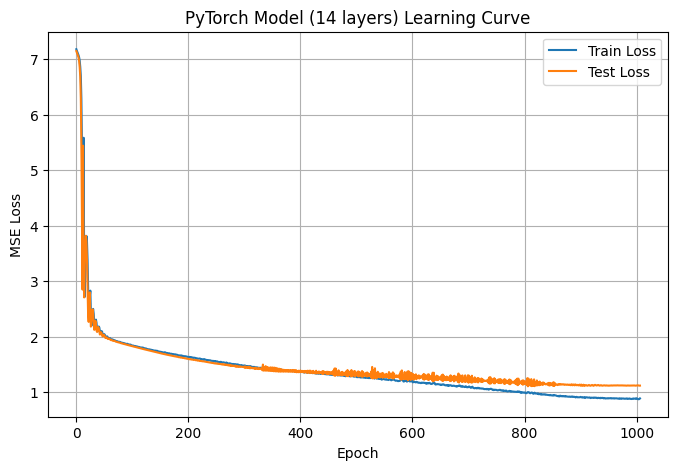

[PyTorch Model (14 layers) - Test Set]
MAE:  0.7980
RMSE: 1.0572
R²:   0.5369

[PyTorch Model (14 layers) - Training Set]
MAE:  0.6846
RMSE: 0.8879
R²:   0.6741


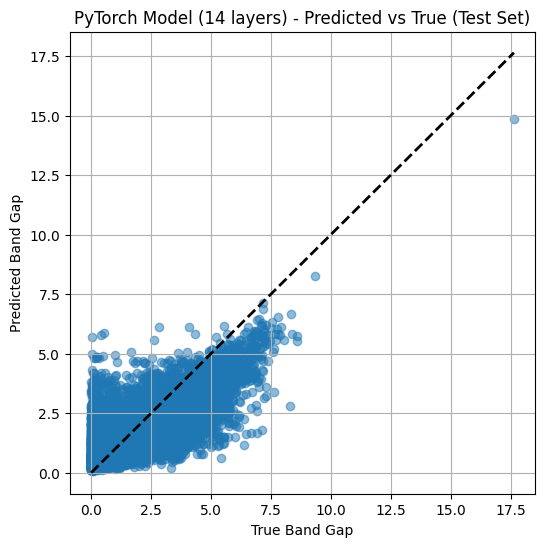

In [59]:
# Make a metrics dictionary
model_layers14_metrics = evaluate_model(
    model_layers14,
    X_train_tensor,
    y_train,
    X_test_tensor,
    y_test
)

# Analyze the model
analyze_model(
    model_layers14_metrics,
    y_test,
    train_losses_layers14,
    test_losses_layers14,
    model_name="PyTorch Model (14 layers)"
)

## Ensemble Predictions

In [60]:
def ensemble_predict(models, X_tensor):
    """
    Averages predictions from multiple models.

    Args:
        models (list): List of trained PyTorch models
        X_tensor (torch.Tensor): Input features

    Returns:
        np.ndarray: Averaged predictions (numpy array)
    """
    preds = []

    for model in models:
        model.eval()
        with torch.no_grad():
            pred = model(X_tensor).detach().cpu().numpy()
            preds.append(pred)

    # Stack and average predictions
    preds = np.stack(preds, axis=0)  # Shape: (num_models, num_samples, 1)
    avg_preds = np.mean(preds, axis=0)  # Shape: (num_samples, 1)

    return avg_preds


In [61]:
# Assume you have 3 trained models
# models["Random Forest"].fit(X_train_processed, y_train)
models = [model_layers6, model_layers10]

# Ensemble predictions on test data
ensemble_preds = ensemble_predict(models, X_test_tensor)

mae = mean_absolute_error(y_test, ensemble_preds)
rmse = mean_squared_error(y_test, ensemble_preds)
r2 = r2_score(y_test, ensemble_preds)

print(f"[Ensemble Results models 6 and 10 layers]")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

[Ensemble Results models 6 and 10 layers]
MAE:  0.7222
RMSE: 0.9657
R²:   0.5999


### Less Layers but more iterations?

In [62]:
# residuals = y_test - y_pred_torch.flatten()

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=y_pred_torch.flatten(), y=residuals)
# plt.axhline(0, linestyle='--', color='red')
# plt.xlabel('Predicted')
# plt.ylabel('Residuals')
# plt.title('Residuals vs. Predicted')
# plt.grid(True)
# plt.show()


In [63]:
# plt.figure(figsize=(8, 6))
# sns.histplot(residuals, kde=True)
# plt.title('Distribution of Residuals')
# plt.xlabel('Residual')
# plt.grid(True)
# plt.show()


#### Posibly Add Weight Initialization

In [64]:
# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         nn.init.kaiming_normal_(m.weight)
#         if m.bias is not None:
#             nn.init.zeros_(m.bias)

# model2.apply(init_weights)

In [65]:
# Print the summaries of all the models based on mae rmse and r2#
# Use also the metrics from the above models

# Summary of all

In [143]:
# Print the summaries of all the models based on mae rmse and r2#
# summarize all model by mae and r2 values
print("\nSummary of all models: band gap range 0.001 - 50 eV")
print(f"{'Model':<30} {'MAE':<10} {'RMSE':<10} {'R²':<10}")
for name, result in results.items():
    print(f"{name:<30} {result['mae']:<10.4f} {np.sqrt(result['mae']):<10.4f} {result['r2']:<10.4f}")

print(f"{'PyTorch 3-layers':<30} {model_layers3_metrics['test']['MAE']:<10.4f} {model_layers3_metrics['test']['RMSE']:<10.4f} {model_layers3_metrics['test']['R2']:<10.4f}")
# print(f"{'PyTorch 3-layers train':<30} {model_layers3_metrics['train']['MAE']:<10.4f} {model_layers3_metrics['train']['RMSE']:<10.4f} {model_layers3_metrics['train']['R2']:<10.4f}")
print(f"{'PyTorch 6-layers':<30} {model_layers6_metrics['test']['MAE']:<10.4f} {model_layers6_metrics['test']['RMSE']:<10.4f} {model_layers6_metrics['test']['R2']:<10.4f}")
# print(f"{'PyTorch 6-layers train':<30} {model_layers6_metrics['train']['MAE']:<10.4f} {model_layers6_metrics['train']['RMSE']:<10.4f} {model_layers6_metrics['train']['R2']:<10.4f}")
print(f"{'PyTorch 8-layers':<30} {model_layers8_metrics['test']['MAE']:<10.4f} {model_layers8_metrics['test']['RMSE']:<10.4f} {model_layers8_metrics['test']['R2']:<10.4f}")
print(f"{'PyTorch 10-layers':<30} {model_layers10_metrics['test']['MAE']:<10.4f} {model_layers10_metrics['test']['RMSE']:<10.4f} {model_layers10_metrics['test']['R2']:<10.4f}")
# print(f"{'PyTorch 10-layers train':<30} {model_layers10_metrics['train']['MAE']:<10.4f} {model_layers10_metrics['train']['RMSE']:<10.4f} {model_layers10_metrics['train']['R2']:<10.4f}")
print(f"{'PyTorch 12-layers':<30} {model_layers12_metrics['test']['MAE']:<10.4f} {model_layers12_metrics['test']['RMSE']:<10.4f} {model_layers12_metrics['test']['R2']:<10.4f}")
print(f"{'PyTorch 14-layers':<30} {model_layers14_metrics['test']['MAE']:<10.4f} {model_layers14_metrics['test']['RMSE']:<10.4f} {model_layers14_metrics['test']['R2']:<10.4f}")
print(f"{'Ensemble 6 and 10 layers':<30} {mae:<10.4f} {rmse:<10.4f} {r2:<10.4f}")


Summary of all models: band gap range 0.001 - 50 eV
Model                          MAE        RMSE       R²        
Dummy                          1.2696     1.1268     -0.0000   
Linear Regression              1.0906     1.0443     0.2239    
Ridge Regression               1.0906     1.0443     0.2239    
Gradient Boosting              0.9227     0.9606     0.4332    
XGBoost                        0.9245     0.9615     0.4314    
Hist Gradient Boosting         0.9203     0.9593     0.4340    
Random Forest                  0.6890     0.8301     0.6345    
Random Forest (tuned)          0.6661     0.8162     0.6511    
PyTorch 3-layers               0.8363     1.1103     0.4893    
PyTorch 6-layers               0.7663     1.0232     0.5663    
PyTorch 8-layers               0.7613     1.0302     0.5603    
PyTorch 10-layers              0.7134     0.9935     0.5911    
PyTorch 12-layers              0.8464     1.1069     0.4924    
PyTorch 14-layers              0.7980     1.0572   

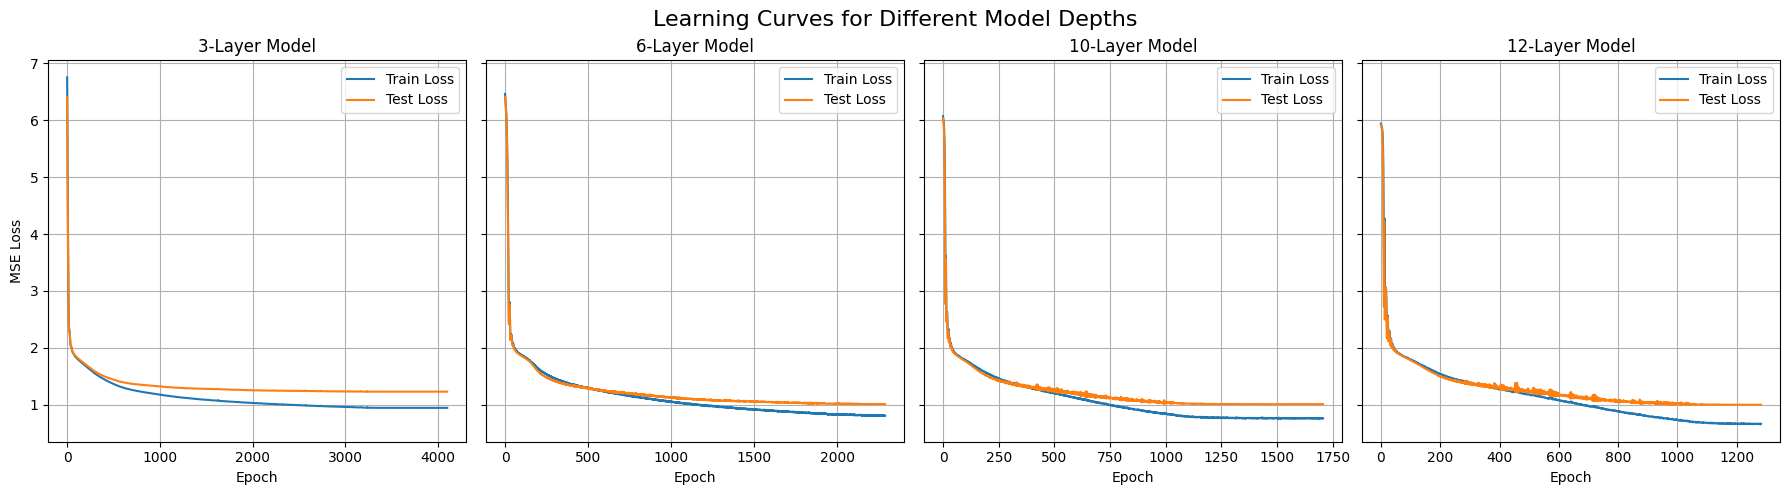

In [67]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharey=True)

# Model: 3 Layers
axes[0].plot(train_losses_layers3, label="Train Loss")
axes[0].plot(test_losses_layers3, label="Test Loss")
axes[0].set_title("3-Layer Model")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE Loss")
axes[0].legend()
axes[0].grid(True)

# Model: 6 Layers
axes[1].plot(train_losses_layers6, label="Train Loss")
axes[1].plot(test_losses_layers6, label="Test Loss")
axes[1].set_title("6-Layer Model")
axes[1].set_xlabel("Epoch")
axes[1].legend()
axes[1].grid(True)

# Model: 10 Layers
axes[2].plot(train_losses_layers10, label="Train Loss")
axes[2].plot(test_losses_layers10, label="Test Loss")
axes[2].set_title("10-Layer Model")
axes[2].set_xlabel("Epoch")
axes[2].legend()
axes[2].grid(True)

# Model: 12 Layers
axes[3].plot(train_losses_layers12, label="Train Loss")
axes[3].plot(test_losses_layers12, label="Test Loss")
axes[3].set_title("12-Layer Model")
axes[3].set_xlabel("Epoch")
axes[3].legend()
axes[3].grid(True)


# Set overall title
fig.suptitle("Learning Curves for Different Model Depths", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()



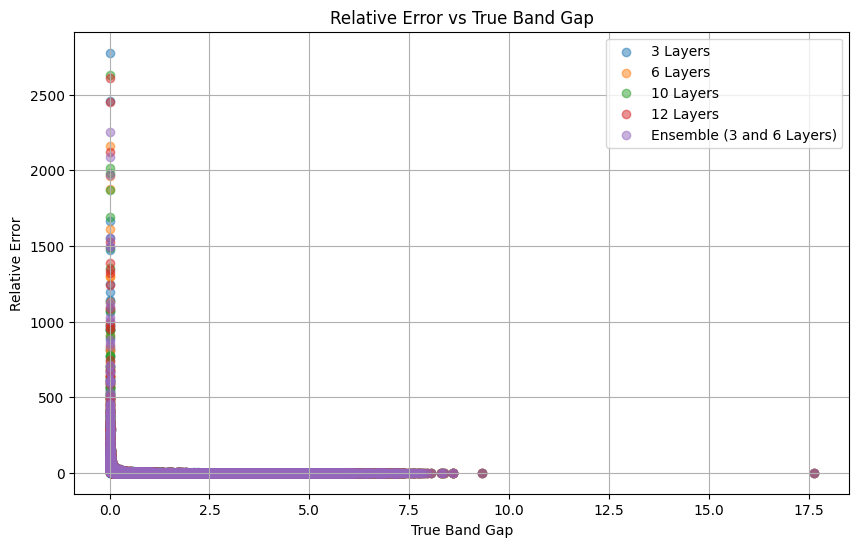

In [68]:
# relative error vs true band gap for 3 6 10 and 12 layers
plt.figure(figsize=(10, 6))
plt.scatter(y_test, np.abs(model_layers3_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5, label="3 Layers")
plt.scatter(y_test, np.abs(model_layers6_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5, label="6 Layers")
plt.scatter(y_test, np.abs(model_layers10_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5, label="10 Layers")
plt.scatter(y_test, np.abs(model_layers12_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5, label="12 Layers")
plt.scatter(y_test, np.abs(ensemble_preds.flatten() - y_test) / y_test, alpha=0.5, label="Ensemble (3 and 6 Layers)")
plt.xlabel("True Band Gap")
plt.ylabel("Relative Error")
plt.title("Relative Error vs True Band Gap")
plt.legend()
plt.grid(True)
plt.show()